# Setup

In [1]:
# mounting Google Drive for consolidated file storage
# skip this step if directly importing files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Senior/Thesis/Data/

Mounted at /content/drive
/content/drive/My Drive/Senior/Thesis/Data


In [2]:
# importing required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing scikit-learn models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error

# unused packages
import requests
import statsmodels.api as sm
from scipy import stats
from datetime import datetime

# Data

## Transforming Items (json) to Features (csv)

### December 07 Data

In [3]:
# reading data from .json
data = pd.read_json("items_Dec07.json")

# useless columns of the dataset to drop
columns_drop = ["id","marketname","slug","priceupdatedat","pricereal","pricerealcreatedat","winlosspercentage","pricemedian","priceavg","pricemin","pricemax","pricesafe","pricesafe24h","pricesafe7d","pricesafe30d","pricesafe90d","itemname","markettradablerestriction","updatedat","itemimage"]
data = data.drop(columns=columns_drop)
data = data.sort_index(axis=0)

# exporting data to .csv
data.to_csv("ItemFeatures_Dec07.csv")

### February 11 Data

In [4]:
# reading data from .json
data = pd.read_json("items_Feb11.json")

# useless columns of the dataset to drop
columns_drop = ["id","marketname","slug","priceupdatedat","pricereal","pricerealcreatedat","winlosspercentage","pricemedian","priceavg","pricemin","pricemax","pricesafe","pricesafe24h","pricesafe7d","pricesafe30d","pricesafe90d","pricereal24h","pricereal7d","pricereal30d","pricereal90d","itemname","markettradablerestriction","updatedat","itemimage"]
data = data.drop(columns=columns_drop)
data = data.sort_index(axis=0)

# exporting data to .csv
data.to_csv("ItemFeatures_Feb11.csv")

### March 25 Data

In [5]:
# reading data from .json
data = pd.read_json("items_Mar25.json")

# useless columns of the dataset to drop
columns_drop = ["id","marketname","slug","priceupdatedat","pricereal","pricerealCreatedAt","winLosspercentage","pricemedian","points","priceavg","pricemin","pricemax","pricereal24h","pricereal7d","pricereal30d","pricereal90d","pricerealchangepercent24h","pricerealchangepercent7d","pricerealchangepercent30d","pricerealchangepercent90d","itemname","markettradablerestriction","updatedat","itemimage"]
data = data.drop(columns=columns_drop)
data = data.sort_index(axis=0)

# exporting data to .csv
data.to_csv("ItemFeatures_Mar25.csv")

## Data Cleaning

In [6]:
# transforming item data into endogenous and exogenous
def dataProcessing(data, old=False):
    # replacing null offer volumes with 0
    data['offervolume'] = data['offervolume'].fillna(0)

    # removes rows of mising data
    num_missing = data.itemgroup.isna().sum()
    print("Number of rows with missing values:", data.itemgroup.isna().sum())
    data = data.dropna(subset=['itemgroup'])

    # indicating distinction between 'not painted' and no possible wear'
    wearData = pd.DataFrame(data[(data.itemgroup == 'pistol') | (data.itemgroup == 'knife') | (data.itemgroup == 'rifle') | (data.itemgroup == 'smg') | (data.itemgroup == 'shotgun') | (data.itemgroup == 'sniper rifle') | (data.itemgroup == 'machinegun') | (data.itemgroup == 'gloves') | (data.itemgroup == 'equipment')])
    wearData['wear'] = wearData['wear'].fillna('np')
    data.loc[wearData.index] = wearData

    # prepping data for back-testing to Dec07 models, which doesn't include the equipment category
    if old:
        data = data.drop(data.loc[data['itemgroup']=='equipment'].index)
        data = data.drop(data.loc[data['unstablereason']=='NEW_ITEM'].index)

    # getting exogenous variables
    # transforming catagorical variables for exogenous variables
    # unstablereason = pd.get_dummies(data['unstablereason'], dtype=int)
    wear = pd.get_dummies(data['wear'], dtype=int)
    itemgroup = pd.get_dummies(data['itemgroup'], dtype=int)
    rarity = pd.get_dummies(data['rarity'], dtype=int)
    quality = pd.get_dummies(data['quality'], dtype=int)
    # gathering other exogenous variables (continual and categorical)
    offervolume = pd.DataFrame(data['offervolume'])
    unstable = pd.DataFrame(data['unstable'])
    stattrak = pd.DataFrame(data['isstattrack'])
    # star = pd.DataFrame(data['isstar'])

    # getting endogenous variable
    latestsoldprice = pd.DataFrame(data['pricelatest'])

    # X = offervolume.join(unstable).join(unstablereason).join(wear).join(itemgroup).join(rarity).join(quality).join(stattrak).join(star)
    X = offervolume.join(unstable).join(wear).join(itemgroup).join(rarity).join(quality).join(stattrak)
    y = latestsoldprice

    return data, X, y

# plots a correlation heatmap of the feature space
def plotCorrelation(X, date):
    # using a correlation heatmap to identify correlating features
    plt.figure(figsize=(56,21))

    # heatmap colors: PRGn, PiYG, BrBG
    heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, cmap='BrBG', annot=True)
    heatmap.set_title(f'{date} Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
    plt.show()

# Prediction Models

## Functions

In [7]:
# given actual and predicted prices, calculate evaluation metrics
def metrics(actuals, predictions):
    rmse = []
    rmsle = []
    mape = []
    for i in range(len(actuals)):
        predictions[i][predictions[i] < 0] = 0
        rmse.append(mean_squared_error(actuals[i], predictions[i], squared=False))
        rmsle.append(mean_squared_log_error(actuals[i], predictions[i], squared=False))
        mape.append(mean_absolute_percentage_error(actuals[i], predictions[i]))
    return rmse, rmsle, mape

# displays the metrics in a nice format
def pretty_print(actuals, predictions, train_date):
    rmse, rmsle, mape = metrics(actuals, predictions)
    dates = ['Dec07', 'Feb11', 'Mar25']
    print(f'Model trained on {dates[train_date-1]} data:\n')
    # root mean squared error (RMSE)
    print('RMSE Scores')
    print(f'{dates[train_date-1]} Train RMSE:', rmse[0])
    print(f'{dates[train_date-1]} Test RMSE:', rmse[1])
    count = 1
    while count < 4 - train_date:
        print(f'{dates[train_date-1+count]} RMSE:', rmse[1+count])
        count += 1

    # root mean squared logarithmic error (RMSLE)
    print('\nRMSLE Scores')
    print(f'{dates[train_date-1]} Train RMSLE:', rmsle[0])
    print(f'{dates[train_date-1]} Test RMSLE:', rmsle[1])
    count = 1
    while count < 4 - train_date:
        print(f'{dates[train_date-1+count]} RMSLE:', rmsle[1+count])
        count += 1

    # mean absolute percentage error (MAPE)
    print('\nMAPE Scores')
    print(f'{dates[train_date-1]} Train MAPE:', mape[0])
    print(f'{dates[train_date-1]} Test MAPE:', mape[1])
    count = 1
    while count < 4 - train_date:
        print(f'{dates[train_date-1+count]} MAPE:', mape[1+count])
        count += 1
    # MAPE turned out to be not too descriptive of a measure

# displays intercept and coefficients for the feature space in a presentatble manner
def show_coefs(model, X):
    features = np.append("intercept", X.columns.values)
    params = np.append(model.intercept_, model.coef_)
    params = np.round(params, 6)
    df = pd.DataFrame()
    df["Variables"], df["Coefficients"] = [features, params]
    print(df)

# splitting the dataset into 80% training and 20% testing
def data_split(X, y, state=None, test_size=0.2):
    if state == None:
        state = np.random.randint(0, 10000)
    print("Seed:", state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)
    y_train = y_train.squeeze()
    return X_train, X_test, y_train, y_test, state

## December 07 Models

### Reading Main (December 07) Data

In [8]:
# reading the data
data_Dec07 = pd.read_csv("ItemFeatures_Dec07.csv", index_col=0)

# useful columns contained in this dataset
data_Dec07.columns

Index(['markethashname', 'color', 'bordercolor', 'pricelatest',
       'pricelatestsell', 'unstable', 'unstablereason', 'offervolume',
       'sold24h', 'sold7d', 'sold30d', 'sold90d', 'wear', 'itemgroup',
       'itemtype', 'rarity', 'quality', 'isstattrack', 'isstar'],
      dtype='object')

In [9]:
data_Dec07, X_Dec07, y_Dec07 = dataProcessing(data_Dec07, old=True)

Number of rows with missing values: 995


### Reading Validation Testing (February 11, March 25) Data

In [10]:
# reading the data
data_Feb11 = pd.read_csv("ItemFeatures_Feb11.csv", index_col=0)

# useful columns contained in this dataset
data_Feb11.columns

Index(['markethashname', 'color', 'bordercolor', 'pricelatest',
       'pricelatestsell', 'unstable', 'unstablereason', 'offervolume',
       'sold24h', 'sold7d', 'sold30d', 'sold90d', 'wear', 'itemgroup',
       'itemtype', 'rarity', 'quality', 'isstattrack', 'isstar'],
      dtype='object')

In [11]:
data_Feb11, X_Feb11, y_Feb11 = dataProcessing(data_Feb11, old=True)

Number of rows with missing values: 1683


In [12]:
# reading the data
data_Mar25 = pd.read_csv("ItemFeatures_Mar25.csv", index_col=0)

# useful columns contained in this dataset
data_Mar25.columns

Index(['markethashname', 'color', 'bordercolor', 'pricelatest',
       'pricelatestsell', 'unstable', 'unstablereason', 'offervolume',
       'sold24h', 'sold7d', 'sold30d', 'sold90d', 'wear', 'itemgroup',
       'itemtype', 'rarity', 'quality', 'isstattrack', 'isstar'],
      dtype='object')

In [13]:
data_Mar25, X_Mar25, y_Mar25 = dataProcessing(data_Mar25, old=True)

Number of rows with missing values: 2067


### Feature Space Correlation/Heatmap

In [14]:
# correlation matrix between the features
X_Dec07.corr()

offervolume  unstable        bs        fn        ft  \
offervolume          1.000000 -0.086491 -0.020517 -0.024174 -0.013692   
unstable            -0.086491  1.000000 -0.002472  0.039890 -0.093210   
bs                  -0.020517 -0.002472  1.000000 -0.129200 -0.135951   
fn                  -0.024174  0.039890 -0.129200  1.000000 -0.144470   
ft                  -0.013692 -0.093210 -0.135951 -0.144470  1.000000   
mw                  -0.023484 -0.021250 -0.138358 -0.147028 -0.154710   
np                  -0.003175  0.036261 -0.015447 -0.016415 -0.017273   
ww                  -0.021387  0.017070 -0.122391 -0.130060 -0.136856   
agent               -0.003510 -0.069735 -0.019903 -0.021150 -0.022255   
collectible         -0.003340 -0.008628 -0.016813 -0.017866 -0.018800   
container            0.032299  0.010531 -0.047606 -0.050589 -0.053232   
gift                -0.000858  0.001722 -0.004336 -0.004608 -0.004849   
gloves              -0.009356  0.088189  0.047290  0.000794  0.034340   
graffiti             0.000601 -0.042471 -0.103469 -0.109952 -0.115697   
key                 -0.002559  0.024915 -0.013017 -0.013833 -0.014556   
knife               -0.027226  0.308949  0.089184  0.059306  0.106030   
machinegun          -0.007082 -0.046527  0.028514  0.033080  0.032093   
music kit           -0.005243 -0.044073 -0.027509 -0.029233 -0.030760   
pass                -0.002338  0.021330 -0.011749 -0.012485 -0.013137   
patch               -0.005196  0.023505 -0.026570 -0.028235 -0.029711   
pistol              -0.021133 -0.139066  0.083820  0.116526  0.097855   
rifle               -0.018773 -0.071946  0.083341  0.084883  0.082553   
shotgun             -0.011712 -0.057229  0.047331  0.064841  0.059207   
smg                 -0.015355 -0.110675  0.070710  0.090121  0.079905   
sniper rifle        -0.010382 -0.050666  0.048203  0.058646  0.055963   
sticker              0.068823  0.077079 -0.213001 -0.226348 -0.238175   
tool                 0.000475 -0.008772 -0.002503 -0.002660 -0.002799   
base grade           0.016425 -0.038853 -0.112837 -0.119907 -0.126173   
classified          -0.018102 -0.009687  0.053944  0.068759  0.063118   
consumer grade       0.005863 -0.064956  0.070406  0.052402  0.057276   
contraband          -0.001367  0.015551 -0.006625  0.001291  0.008631   
covert              -0.031707  0.279925  0.106810  0.077029  0.119793   
distinguished       -0.001699 -0.035100 -0.010018 -0.010646 -0.011202   
exceptional         -0.001766 -0.035100 -0.010018 -0.010646 -0.011202   
exotic              -0.017039  0.083531 -0.085282 -0.090626 -0.095361   
extraordinary       -0.016780  0.160652 -0.028855 -0.059108 -0.042927   
high grade           0.118924 -0.040133 -0.131418 -0.139653 -0.146950   
industrial grade    -0.010553 -0.005467  0.047643  0.063449  0.052308   
master              -0.001862 -0.035100 -0.010018 -0.010646 -0.011202   
mil-spec grade      -0.023753 -0.217756  0.086445  0.121110  0.102101   
remarkable          -0.013597  0.016453 -0.100280 -0.106564 -0.112132   
restricted          -0.022540 -0.123557  0.065269  0.098297  0.087558   
superior            -0.001683 -0.033985 -0.009699 -0.010307 -0.010846   
normal               0.049598 -0.207941 -0.166273 -0.146603 -0.188110   
strange             -0.028235 -0.076657  0.087125  0.102626  0.094416   
tournament          -0.014448  0.053296  0.054061  0.058383  0.070692   
unusual             -0.029260  0.325425  0.101965  0.056537  0.113182   
isstattrack         -0.034132  0.033799  0.101921  0.110292  0.137143   

                        mw        np        ww     agent  collectible  ...  \
offervolume      -0.023484 -0.003175 -0.021387 -0.003510    -0.003340  ...   
unstable         -0.021250  0.036261  0.017070 -0.069735    -0.008628  ...   
bs               -0.138358 -0.015447 -0.122391 -0.019903    -0.016813  ...   
fn               -0.147028 -0.016415 -0.130060 -0.021150    -0.017866  ...   
ft               -0.154710 -0.017273 -0.136856 -0.

It is hard to discern any relationship just by looking at numbers in a table. Instead, we try to represent the correlation graph through a heatmap.

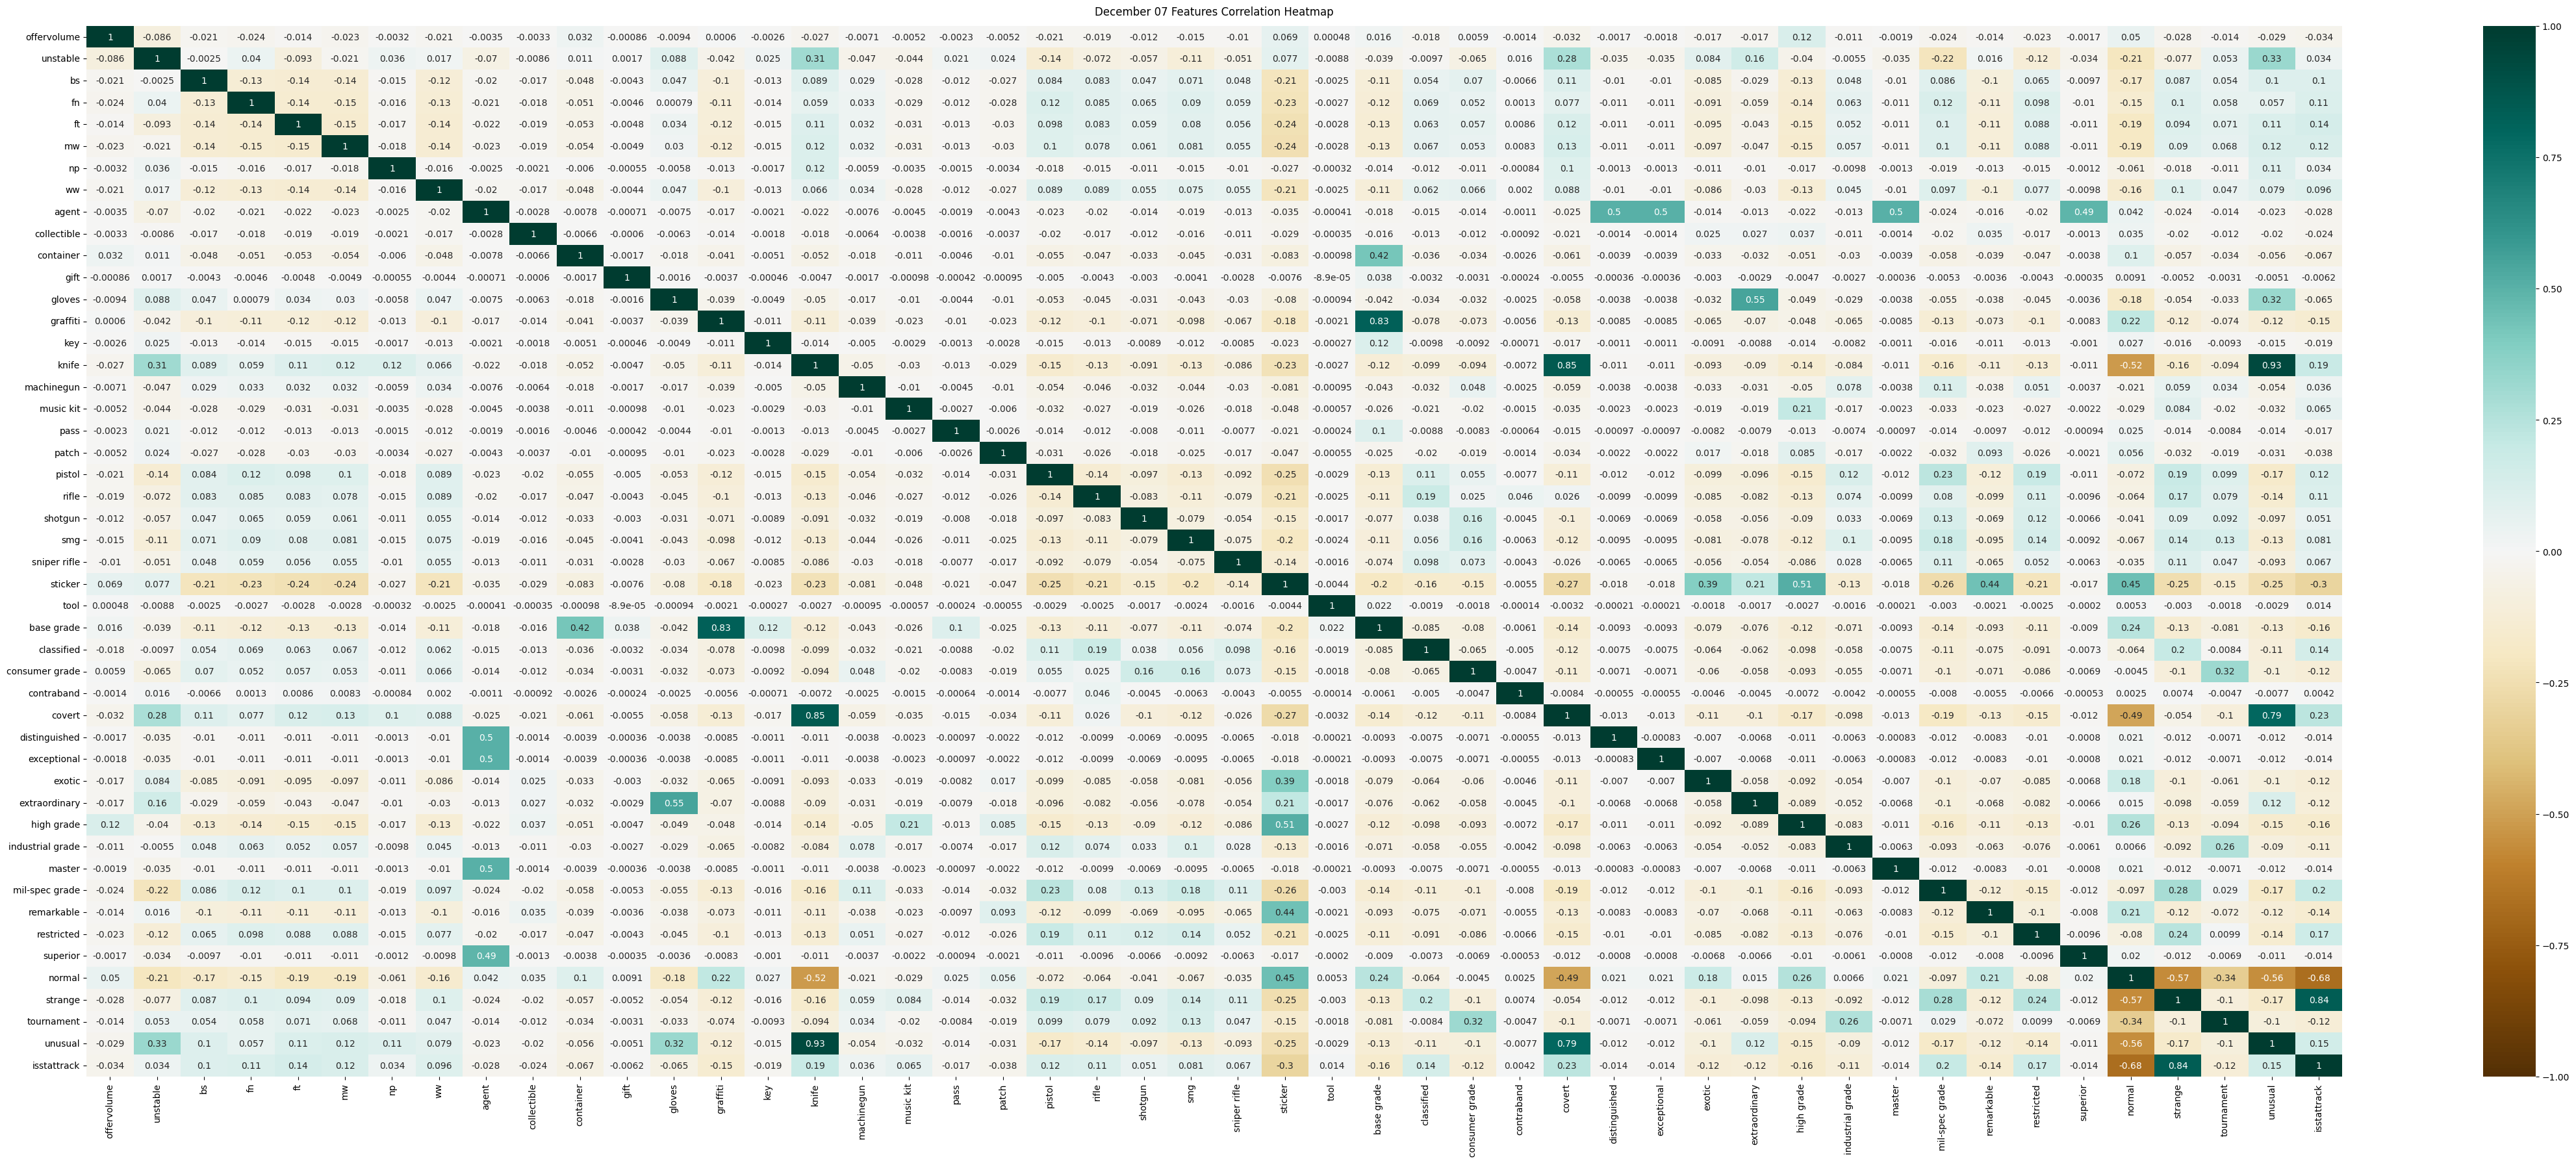

In [15]:
plotCorrelation(X_Dec07, "December 07")

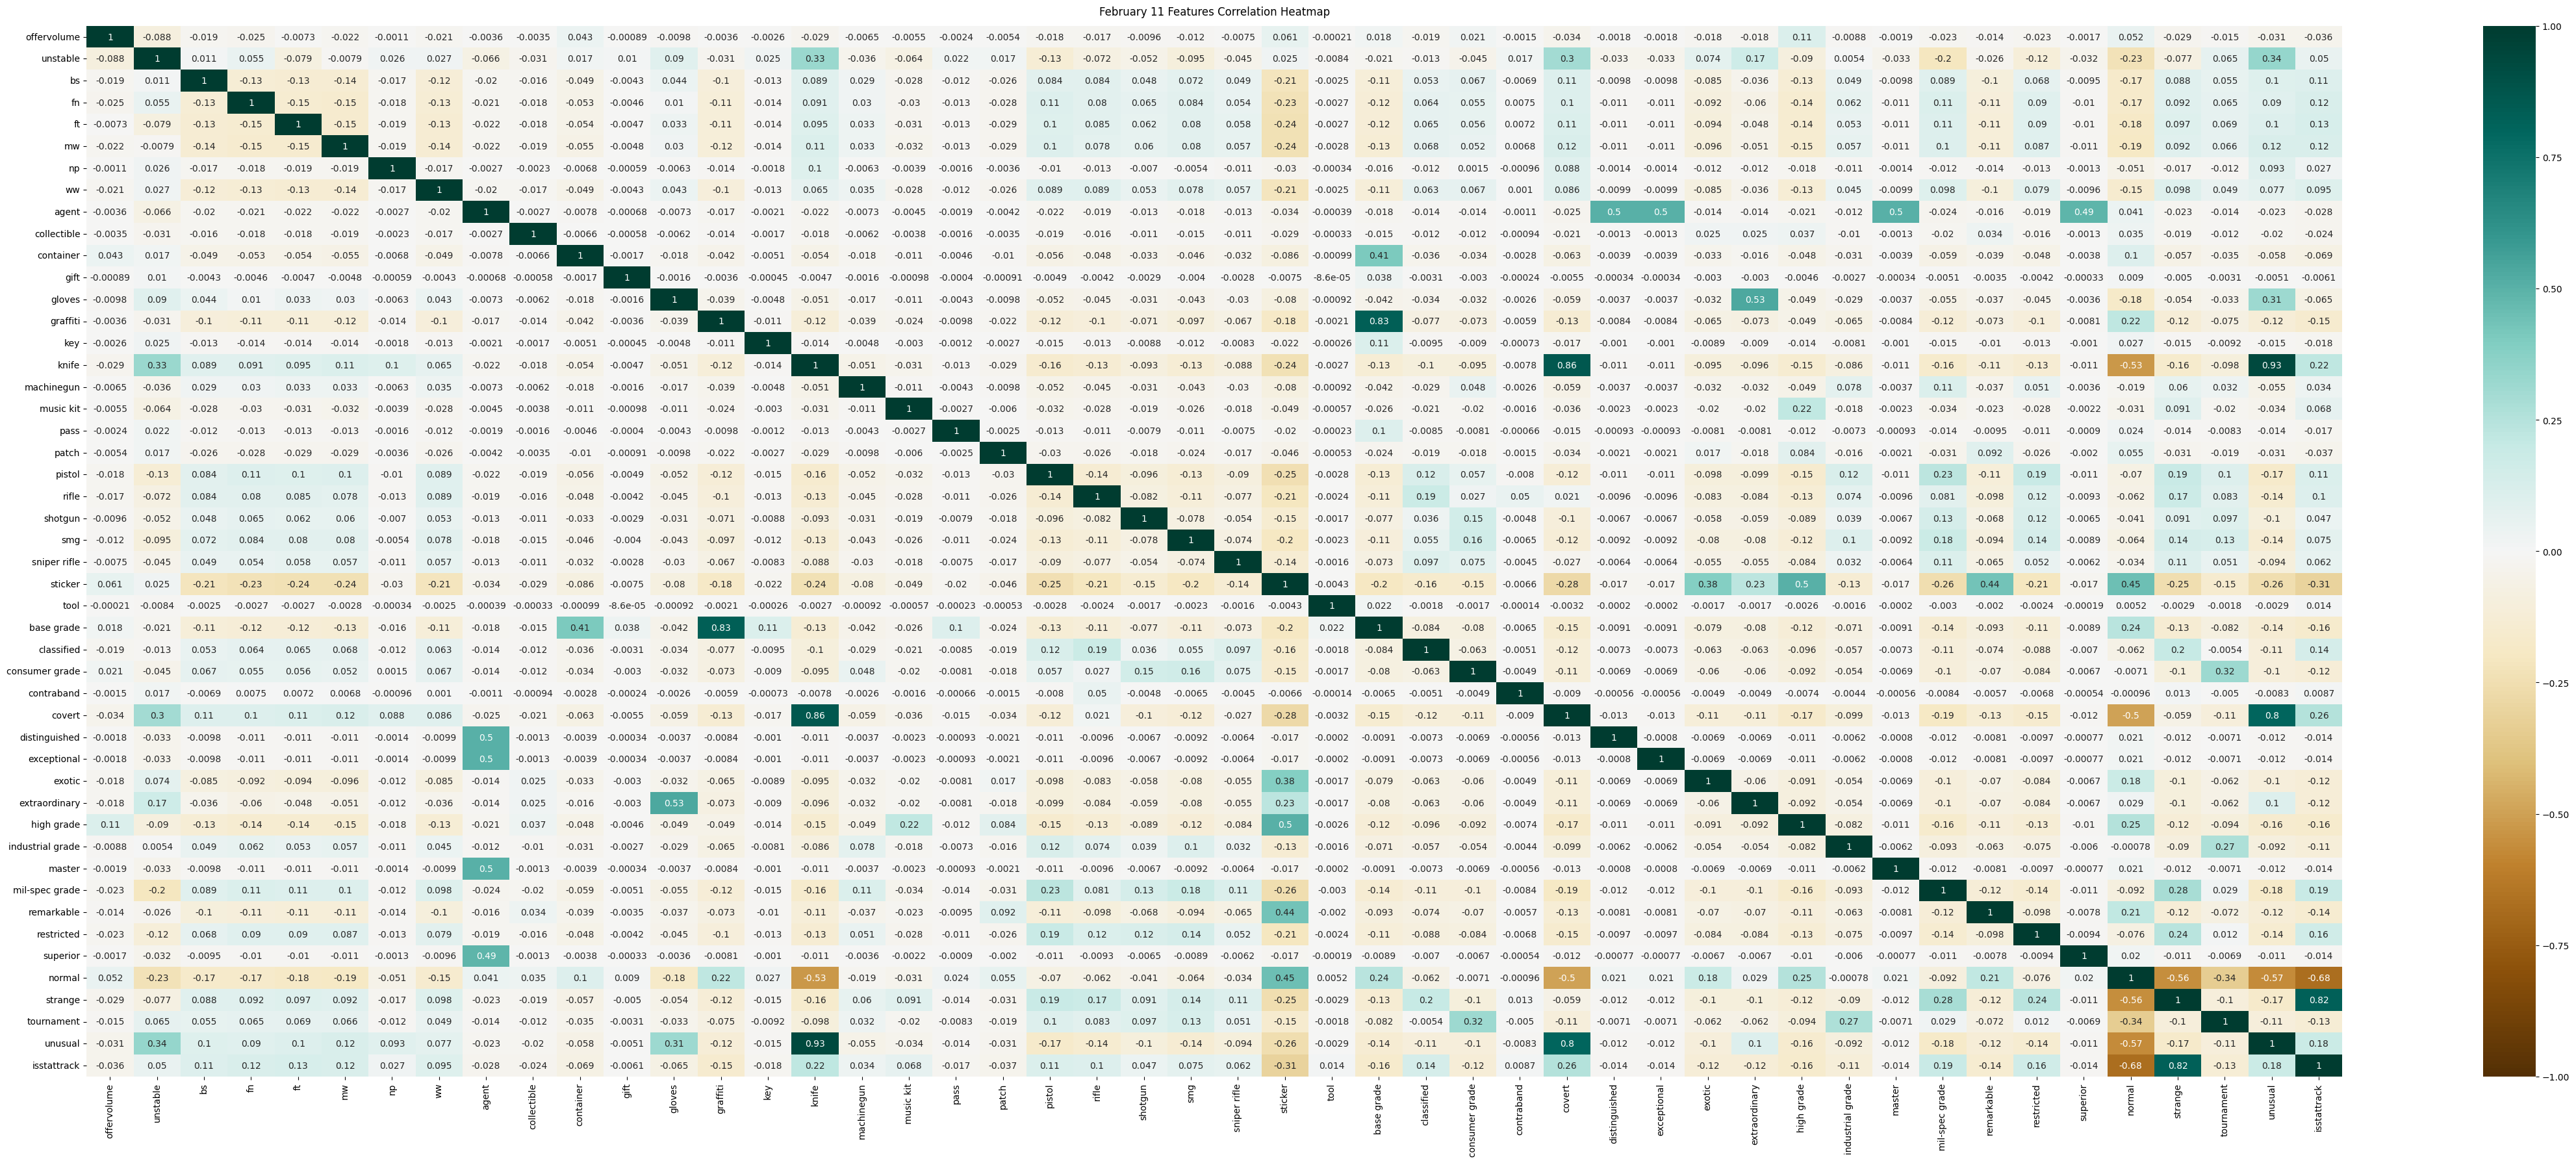

In [16]:
plotCorrelation(X_Feb11, "February 11")

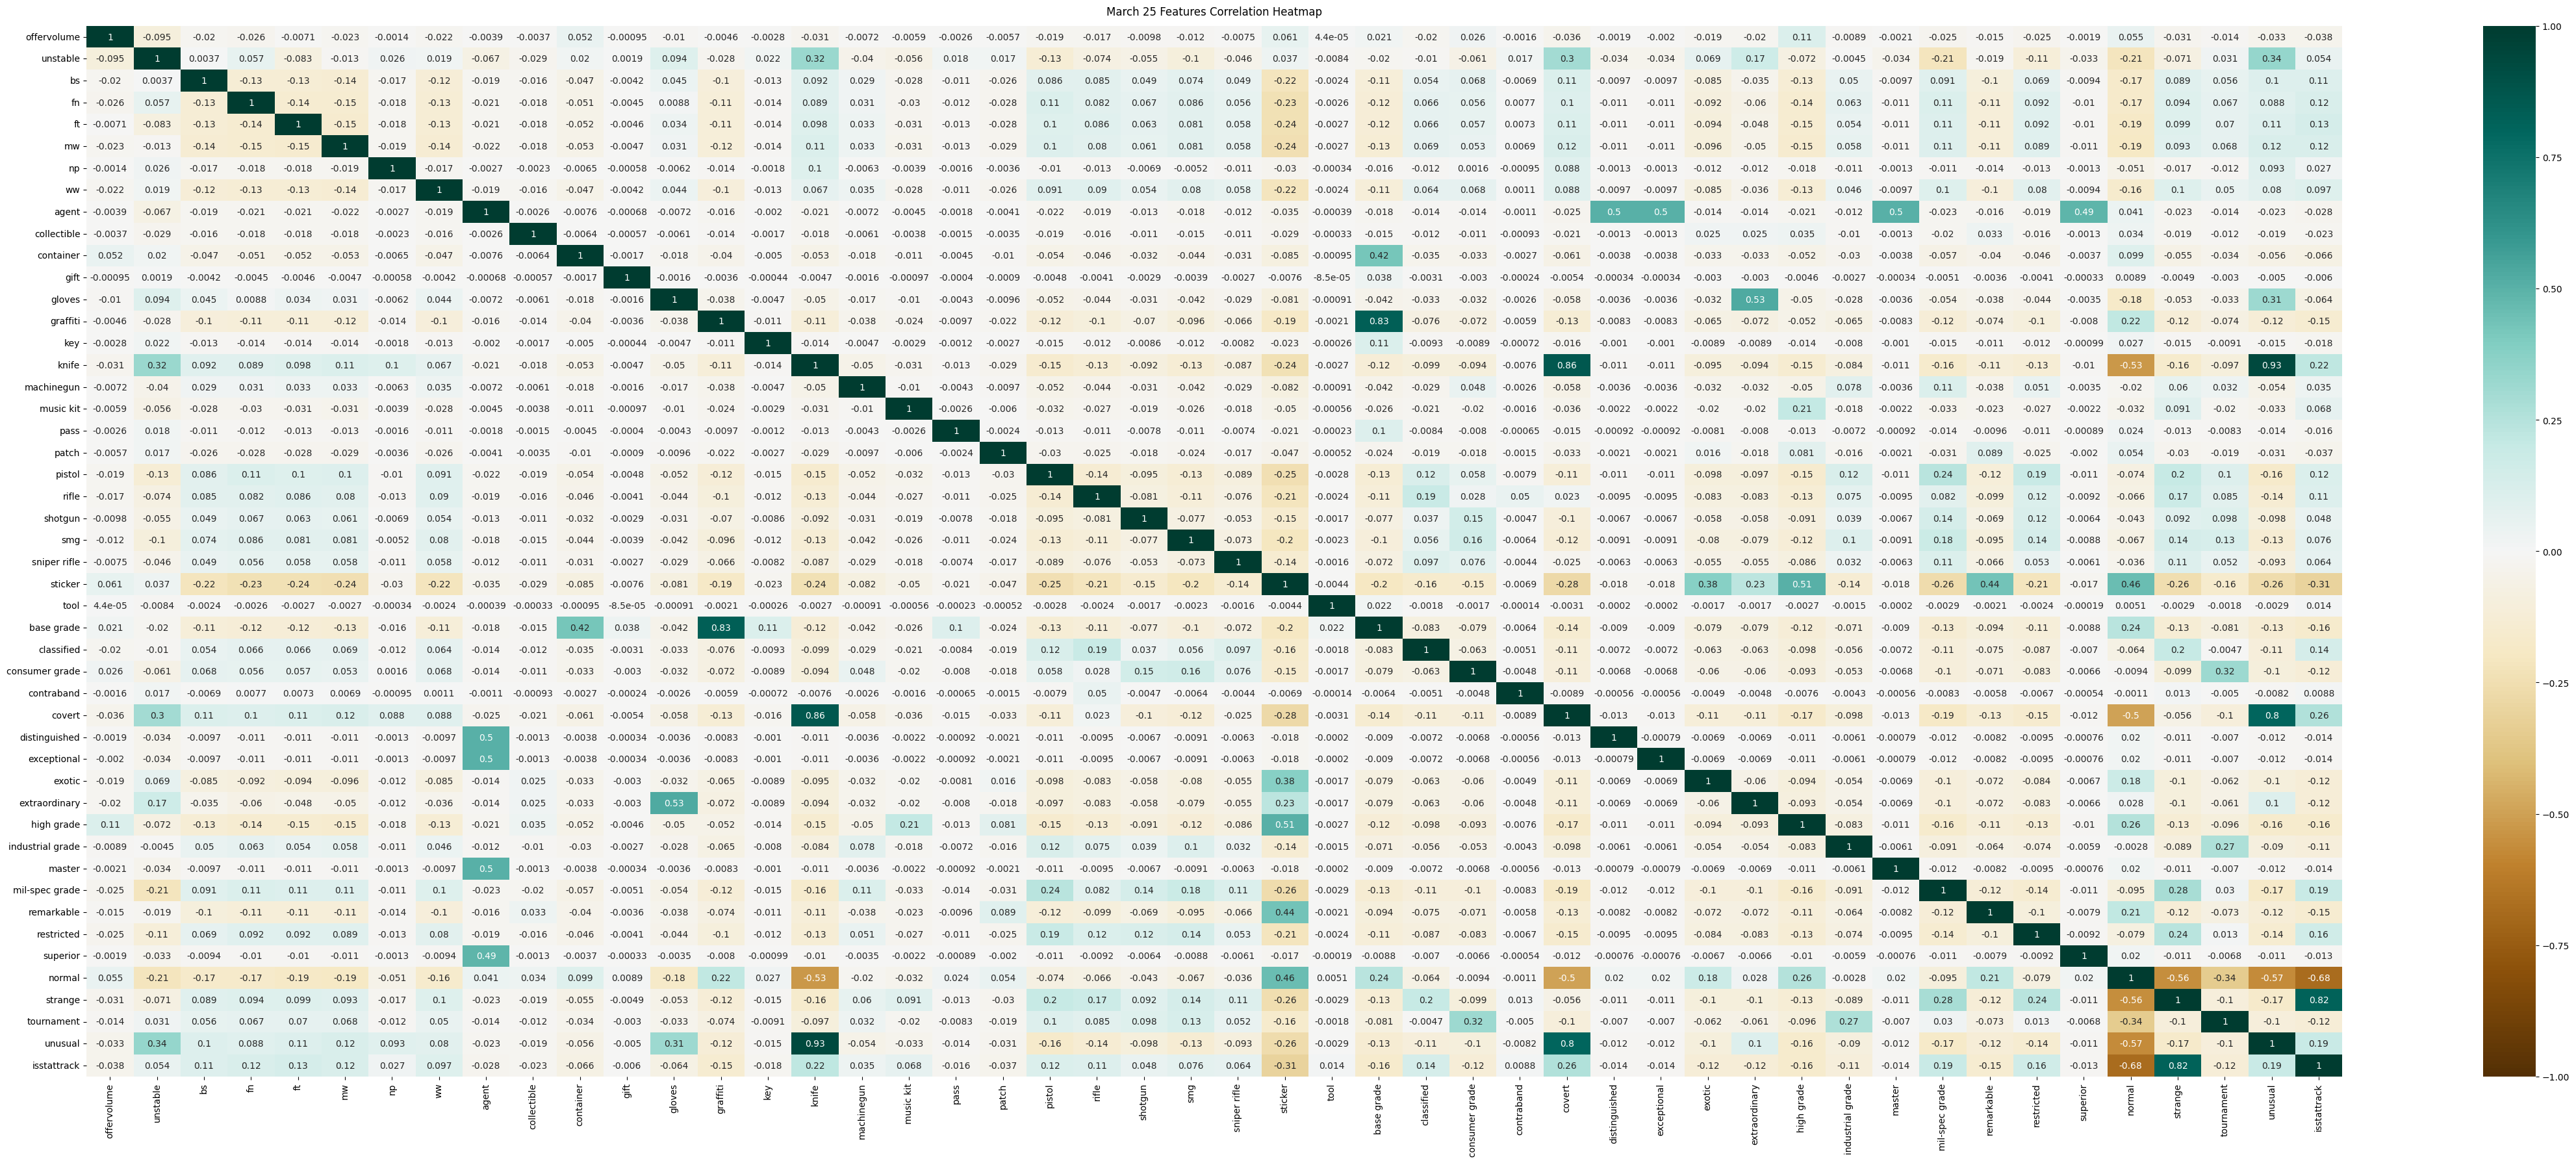

In [17]:
plotCorrelation(X_Mar25, "March 25")

### Train/Test Split

In [18]:
# splitting data into training and testing portions randomly
X_train, X_test, y_train, y_test, seed = data_split(X_Dec07, y_Dec07)

Seed: 2180


In [19]:
X_train

offervolume  unstable  bs  fn  ft  mw  np  ww  agent  collectible  ...  \
10705         46.0         1   0   1   0   0   0   0      0            0  ...   
16698         27.0         1   0   0   0   0   0   0      0            0  ...   
15521         40.0         1   0   0   0   0   0   0      0            0  ...   
16515         50.0         1   0   0   0   0   0   0      0            0  ...   
13583       1473.0         0   0   0   1   0   0   0      0            0  ...   
...            ...       ...  ..  ..  ..  ..  ..  ..    ...          ...  ...   
8537         100.0         1   0   0   0   0   0   0      0            0  ...   
19508        107.0         1   0   0   0   0   0   0      0            0  ...   
7709          17.0         1   0   0   0   0   0   0      0            0  ...   
2916           4.0         1   0   0   0   0   0   1      0            0  ...   
3816          66.0         1   0   0   0   0   0   0      0            0  ...   

       master  mil-spec grade  remarkable  restricted  superior  normal  \
10705       0               0           0           0         0       0   
16698       0               0           0           0         0       1   
15521       0               0           0           0         0       1   
16515       0               0           0           0         0       1   
13583       0               1           0           0         0       0   
...       ...             ...         ...         ...       ...     ...   
8537        0               0           0           0         0       1   
19508       0               0           1           0         0       1   
7709        0               0           0           0         0       1   
2916        0               0           0           0         0       0   
3816        0               0           0           0         0       1   

       strange  tournament  unusual  isstattrack  
10705        0           1        0            0  
16698        0           0        0            0  
15521        0           0        0            0  
16515        0           0        0            0  
13583        1           0        0            1  
...        ...         ...      ...          ...  
8537         0           0        0            0  
19508        0           0        0            0  
7709         0           0        0            0  
2916         0           0        1            0  
3816         0           0        0            0  

[15520 rows x 48 columns]

### Linear Models

#### Ordinary Least Squares (OLS)

In [20]:
print('Ordinary Least Squares')
reg = LinearRegression().fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))

Ordinary Least Squares
Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 219.66539482209762
Dec07 Test RMSE: 249.76628686574614
Feb11 RMSE: 238.98996094464687
Mar25 RMSE: 237.7620272823738

RMSLE Scores
Dec07 Train RMSLE: 1.8356865252718784
Dec07 Test RMSLE: 1.8560249961523005
Feb11 RMSLE: 1.8148605979064627
Mar25 RMSLE: 1.8201594889681654

MAPE Scores
Dec07 Train MAPE: 28.736906095008507
Dec07 Test MAPE: 31.023689751761818
Feb11 MAPE: 32969473663971.695
Mar25 MAPE: 28273231833898.324

R-Squared: 0.4049438957569267


In [21]:
show_coefs(reg, X_Dec07)

           Variables  Coefficients
0          intercept    159.777597
1        offervolume      0.000044
2           unstable     52.407899
3                 bs     10.426975
4                 fn    147.013595
5                 ft     29.082931
6                 mw     94.499655
7                 np    204.663918
8                 ww     18.113961
9              agent   -100.811674
10       collectible    -57.699588
11         container     -0.805054
12              gift     11.656120
13            gloves    104.355799
14          graffiti    -65.794629
15               key    -73.922563
16             knife     55.863785
17        machinegun     61.850016
18         music kit    -16.340713
19              pass     22.830222
20             patch    -56.560937
21            pistol     39.201482
22             rifle     65.882233
23           shotgun     38.749583
24               smg     42.454695
25      sniper rifle     95.443443
26           sticker    -44.702337
27              tool

#### Ridge

In [22]:
print('Ridge Regression')
reg = RidgeCV(alphas=np.arange(0.001, 10, 0.001)).fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))
print("Alpha:", reg.alpha_)

Ridge Regression
Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 219.69740667414112
Dec07 Test RMSE: 249.90225638588078
Feb11 RMSE: 239.03164913069713
Mar25 RMSE: 237.7881070182021

RMSLE Scores
Dec07 Train RMSLE: 1.8394667925671158
Dec07 Test RMSLE: 1.8592928087630827
Feb11 RMSLE: 1.818449048871497
Mar25 RMSLE: 1.8230614402700538

MAPE Scores
Dec07 Train MAPE: 32.26162691954032
Dec07 Test MAPE: 35.90877639785344
Feb11 MAPE: 32762867746780.594
Mar25 MAPE: 28071360372710.633

R-Squared: 0.40477953425442004
Alpha: 0.015


In [23]:
show_coefs(reg, X_Dec07)

           Variables  Coefficients
0          intercept    160.014972
1        offervolume      0.000168
2           unstable     52.413162
3                 bs      9.473263
4                 fn    146.058250
5                 ft     28.134872
6                 mw     93.550439
7                 np    203.622643
8                 ww     17.162653
9              agent   -101.190864
10       collectible    -57.240954
11         container     -0.358651
12              gift     12.010552
13            gloves    105.582838
14          graffiti    -65.348223
15               key    -73.431719
16             knife     54.743615
17        machinegun     60.859784
18         music kit    -15.907951
19              pass     23.257816
20             patch    -56.121697
21            pistol     38.215995
22             rifle     64.912253
23           shotgun     37.762706
24               smg     41.468475
25      sniper rifle     94.456456
26           sticker    -44.271509
27              tool

#### LASSO

In [24]:
print('LASSO Regression')
reg = LassoCV(alphas=np.arange(0.001, 10, 0.001), max_iter=100000).fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))
print("Alpha:", reg.alpha_)

LASSO Regression
Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 219.67165084785074
Dec07 Test RMSE: 249.76996084397365
Feb11 RMSE: 238.99321472826844
Mar25 RMSE: 237.7639086969902

RMSLE Scores
Dec07 Train RMSLE: 1.8359057028367312
Dec07 Test RMSLE: 1.855857833024575
Feb11 RMSLE: 1.8148960967051477
Mar25 RMSLE: 1.8201966072477904

MAPE Scores
Dec07 Train MAPE: 28.744281941504575
Dec07 Test MAPE: 31.01963735615182
Feb11 MAPE: 32955766021708.99
Mar25 MAPE: 28264944110554.332

R-Squared: 0.40493172614003825
Alpha: 0.004


In [25]:
show_coefs(reg, X_Dec07)

           Variables  Coefficients
0          intercept     32.784076
1        offervolume      0.000044
2           unstable     52.426664
3                 bs    -18.653182
4                 fn    117.856046
5                 ft      0.000000
6                 mw     65.381992
7                 np    173.736503
8                 ww    -10.957654
9              agent      0.000000
10       collectible    -30.390186
11         container     24.813600
12              gift      6.444508
13            gloves    144.792676
14          graffiti    -39.956752
15               key    -45.505945
16             knife      0.000000
17        machinegun     19.104969
18         music kit      8.244156
19              pass     45.556486
20             patch    -30.571850
21            pistol     -3.247040
22             rifle     23.476672
23           shotgun     -3.669965
24               smg     -0.000000
25      sniper rifle     52.896614
26           sticker    -19.401675
27              tool

#### Elastic Net

In [26]:
print('Elastic Net Regression')
reg = ElasticNetCV(alphas=np.arange(0.001, 10, 0.001), max_iter=100000, l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))
print("Alpha:", reg.alpha_)
print("L1 Ratio:", reg.l1_ratio_)

Elastic Net Regression
Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 219.66895746760423
Dec07 Test RMSE: 249.76788708269413
Feb11 RMSE: 238.9877806539861
Mar25 RMSE: 237.7569252551959

RMSLE Scores
Dec07 Train RMSLE: 1.8360200402848017
Dec07 Test RMSLE: 1.8562805391189827
Feb11 RMSLE: 1.815134734842502
Mar25 RMSLE: 1.8204257310763505

MAPE Scores
Dec07 Train MAPE: 28.75975568497061
Dec07 Test MAPE: 31.04031298080504
Feb11 MAPE: 32968476342770.266
Mar25 MAPE: 28297332914672.47

R-Squared: 0.4049294818036311
Alpha: 0.001
L1 Ratio: 0.99


In [27]:
show_coefs(reg, X_Dec07)

           Variables  Coefficients
0          intercept    125.631072
1        offervolume      0.000044
2           unstable     52.474055
3                 bs      0.000000
4                 fn    136.560723
5                 ft     18.718817
6                 mw     84.121199
7                 np    192.928665
8                 ww      7.706855
9              agent    -90.144794
10       collectible    -55.138622
11         container      0.933855
12              gift      5.329819
13            gloves     99.054958
14          graffiti    -63.974134
15               key    -71.047725
16             knife      0.000000
17        machinegun     23.032896
18         music kit    -14.379257
19              pass     23.654725
20             patch    -54.521117
21            pistol      0.470463
22             rifle     27.341443
23           shotgun      0.000000
24               smg      3.711751
25      sniper rifle     56.691803
26           sticker    -42.918053
27              tool

### Non-Linear Models

#### Polynomial Regression

In [28]:
# initializing a polynomial transformer of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_Dec07)

# splitting the polynomially transformed data with the same seed (state) as before
poly_X_train, poly_X_test, poly_y_train, poly_y_test, _ = data_split(poly_features, y_Dec07, state=seed, test_size=0.2)

Seed: 2180


In [29]:
# fitting validation data to a polynomial degree
poly_X_Feb11 = poly.fit_transform(X_Feb11)
poly_X_Mar25 = poly.fit_transform(X_Mar25)

In [30]:
print('Polynomial Regression with no Regularization')
reg = LinearRegression().fit(poly_X_train, poly_y_train)
true_vals = [poly_y_train, poly_y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(poly_X_train), reg.predict(poly_X_test), reg.predict(poly_X_Feb11), reg.predict(poly_X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(poly_X_train, poly_y_train))

Polynomial Regression with no Regularization
Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 190.22334429643448
Dec07 Test RMSE: 268.63507487829844
Feb11 RMSE: 233.04918197550774
Mar25 RMSE: 219.06700782866454

RMSLE Scores
Dec07 Train RMSLE: 1.5091425073113327
Dec07 Test RMSLE: 1.5204524138299673
Feb11 RMSLE: 1.5196797191127152
Mar25 RMSLE: 1.5031639691431684

MAPE Scores
Dec07 Train MAPE: 14.927302746322042
Dec07 Test MAPE: 15.634283751926931
Feb11 MAPE: 16346871741889.639
Mar25 MAPE: 32137157307530.285

R-Squared: 0.548465217352217


#### Kernel Ridge

##### Cosine

In [31]:
print('Kernel Ridge with the Cosine Kernel')
reg = KernelRidge(alpha=1.0, kernel='cosine').fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Cosine Kernel
Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 162.68973059841161
Dec07 Test RMSE: 177.02726405572784
Feb11 RMSE: 178.41814298459843
Mar25 RMSE: 176.6706991128969

RMSLE Scores
Dec07 Train RMSLE: 1.2420267016630244
Dec07 Test RMSLE: 1.2278835030701967
Feb11 RMSLE: 1.2473864606355625
Mar25 RMSLE: 1.2313166635473827

MAPE Scores
Dec07 Train MAPE: 4.456206352055945
Dec07 Test MAPE: 4.1702939010427205
Feb11 MAPE: 238159789307469.34
Mar25 MAPE: 325817154534054.9

R-Squared: 0.676126034099835


##### Radial Basis Function (RBF)

In [32]:
print('Kernel Ridge with the RBF Kernel')
reg = KernelRidge(alpha=1.0, kernel='rbf').fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the RBF Kernel
Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 158.7205808584977
Dec07 Test RMSE: 174.38189771296948
Feb11 RMSE: 175.89751645618233
Mar25 RMSE: 174.76330286289567

RMSLE Scores
Dec07 Train RMSLE: 0.9346137281473899
Dec07 Test RMSLE: 0.9884179425741357
Feb11 RMSLE: 1.0209197517495014
Mar25 RMSLE: 1.0027203216278284

MAPE Scores
Dec07 Train MAPE: 3.4478285683349386
Dec07 Test MAPE: 3.873463039487571
Feb11 MAPE: 1112383124678352.1
Mar25 MAPE: 664663255071514.8

R-Squared: 0.6921175489959743


##### Laplacian

In [33]:
print('Kernel Ridge with the Laplacian Kernel')
reg = KernelRidge(alpha=1.0, kernel='laplacian').fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Laplacian Kernel
Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 159.13893631144197
Dec07 Test RMSE: 174.23081590681645
Feb11 RMSE: 176.84649643722395
Mar25 RMSE: 176.1292036921796

RMSLE Scores
Dec07 Train RMSLE: 0.9393538147100705
Dec07 Test RMSLE: 0.974406759408747
Feb11 RMSLE: 1.012674089361356
Mar25 RMSLE: 0.9823924825247518

MAPE Scores
Dec07 Train MAPE: 2.545229030314742
Dec07 Test MAPE: 2.751070873695258
Feb11 MAPE: 1030787848054873.4
Mar25 MAPE: 637383860607540.9

R-Squared: 0.6900568560402678


##### Polynomial

In [37]:
print('Kernel Ridge with the Polynomial Kernel (Degree 2)')
reg = KernelRidge(alpha=1.0, kernel='polynomial', degree=2).fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Polynomial Kernel (Degree 2)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 304.52890954255116
Dec07 Test RMSE: 341.2239505919438
Feb11 RMSE: 316.82482373472493
Mar25 RMSE: 316.4836922989787

RMSLE Scores
Dec07 Train RMSLE: 3.0581389005252353
Dec07 Test RMSLE: 3.0936138397793482
Feb11 RMSLE: 3.0969436246047217
Mar25 RMSLE: 3.0874581551809595

MAPE Scores
Dec07 Train MAPE: 14.276918394679482
Dec07 Test MAPE: 30.720845424550813
Feb11 MAPE: 6245755760.088226
Mar25 MAPE: 3807603500.6714263

R-Squared: -0.13178454069106382


In [35]:
print('Kernel Ridge with the Polynomial Kernel (Degree 3)')
reg = KernelRidge(alpha=1.0, kernel='polynomial').fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Polynomial Kernel (Degree 3)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 304.2850201088528
Dec07 Test RMSE: 338.33774077003727
Feb11 RMSE: 315.79867794056787
Mar25 RMSE: 316.1695622033672

RMSLE Scores
Dec07 Train RMSLE: 3.0592852740448726
Dec07 Test RMSLE: 3.0941333171883856
Feb11 RMSLE: 3.0959908686276423
Mar25 RMSLE: 3.088057685472722

MAPE Scores
Dec07 Train MAPE: 1.0049747197178187
Dec07 Test MAPE: 1.0064393514337462
Feb11 MAPE: 1.005483507340067
Mar25 MAPE: 1.0037233953991023

R-Squared: -0.12998343020219383


##### Sigmoid

In [36]:
print('Kernel Ridge with the Sigmoid Kernel')
reg = KernelRidge(alpha=1.0, kernel='sigmoid').fit(X_train, y_train)
true_vals = [y_train, y_test, y_Feb11, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Feb11), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 1)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Sigmoid Kernel


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model trained on Dec07 data:

RMSE Scores
Dec07 Train RMSE: 222.5898575291863
Dec07 Test RMSE: 234.8328082138173
Feb11 RMSE: 244.8061150791416
Mar25 RMSE: 238.05412794164198

RMSLE Scores
Dec07 Train RMSLE: 2.586278479632155
Dec07 Test RMSLE: 2.574360840589456
Feb11 RMSLE: 2.527883170281592
Mar25 RMSLE: 2.569772954587062

MAPE Scores
Dec07 Train MAPE: 180.3342224256546
Dec07 Test MAPE: 186.0714571832317
Feb11 MAPE: 3696794519092533.0
Mar25 MAPE: 220334471799294.9

R-Squared: 0.2280285695197094


## February 11 Models

### Reading Main (February 11) Data

In [38]:
# reading the data
data_Feb11 = pd.read_csv("ItemFeatures_Feb11.csv", index_col=0)

# useful columns contained in this dataset
data_Feb11.columns

Index(['markethashname', 'color', 'bordercolor', 'pricelatest',
       'pricelatestsell', 'unstable', 'unstablereason', 'offervolume',
       'sold24h', 'sold7d', 'sold30d', 'sold90d', 'wear', 'itemgroup',
       'itemtype', 'rarity', 'quality', 'isstattrack', 'isstar'],
      dtype='object')

In [39]:
data_Feb11, X_Feb11, y_Feb11 = dataProcessing(data_Feb11, old=False)

Number of rows with missing values: 1683


### Reading Validation Testing (March 25) Data

In [40]:
# reading the data
data_Mar25 = pd.read_csv("ItemFeatures_Mar25.csv", index_col=0)

# useful columns contained in this dataset
data_Mar25.columns

Index(['markethashname', 'color', 'bordercolor', 'pricelatest',
       'pricelatestsell', 'unstable', 'unstablereason', 'offervolume',
       'sold24h', 'sold7d', 'sold30d', 'sold90d', 'wear', 'itemgroup',
       'itemtype', 'rarity', 'quality', 'isstattrack', 'isstar'],
      dtype='object')

In [41]:
data_Mar25, X_Mar25, y_Mar25 = dataProcessing(data_Mar25, old=False)

Number of rows with missing values: 2067


### Feature Space Correlation/Heatmap

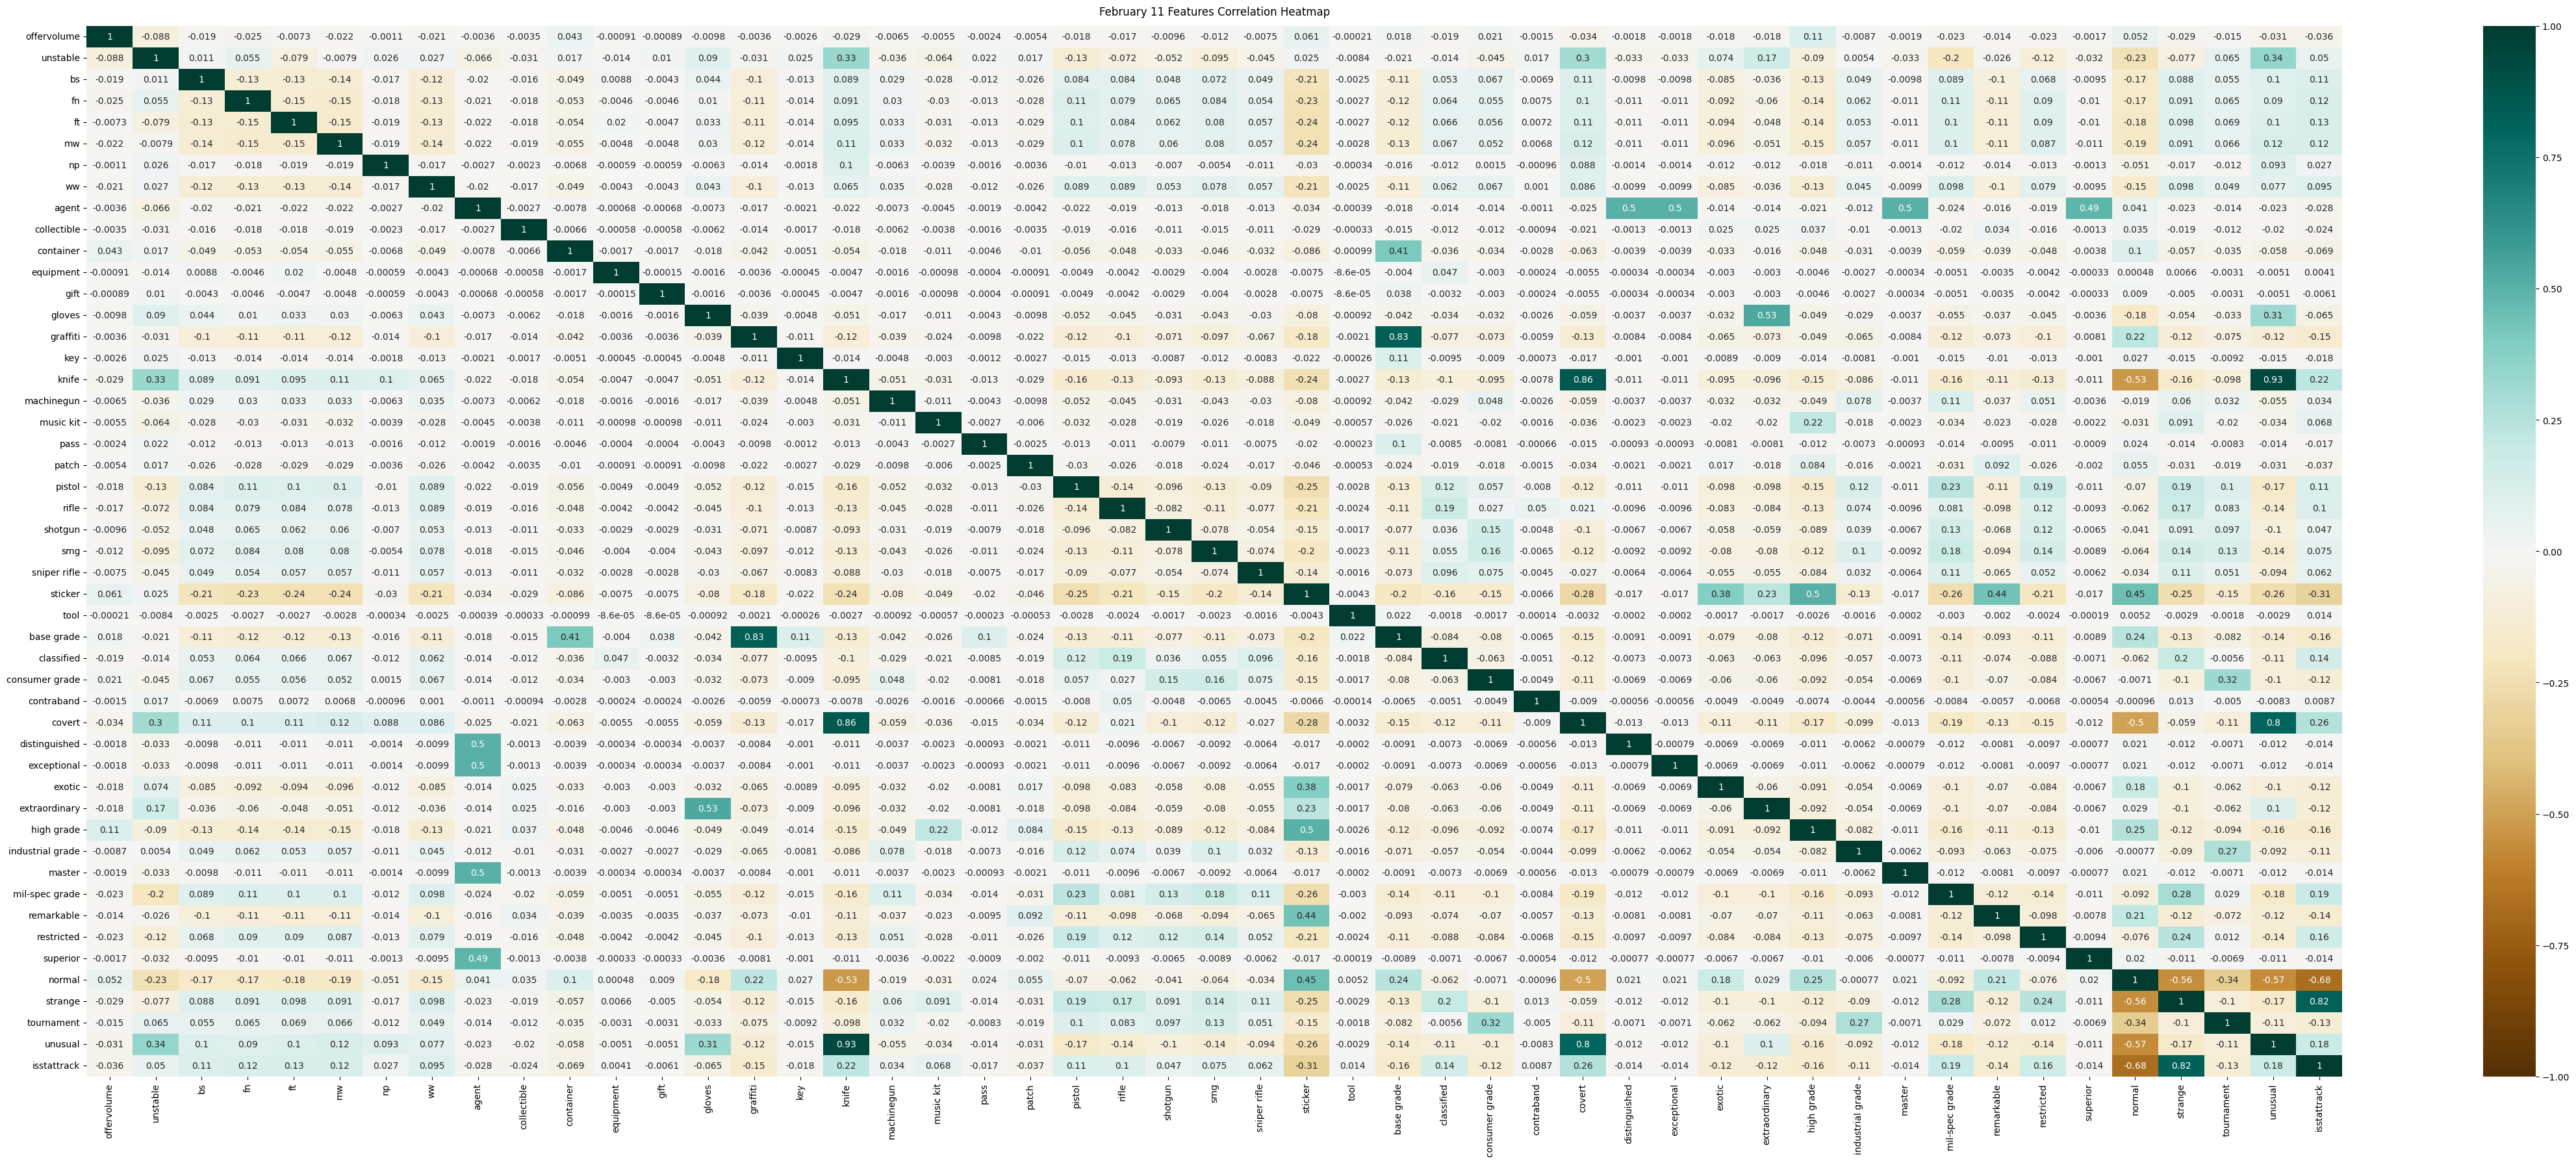

In [42]:
plotCorrelation(X_Feb11, "February 11")

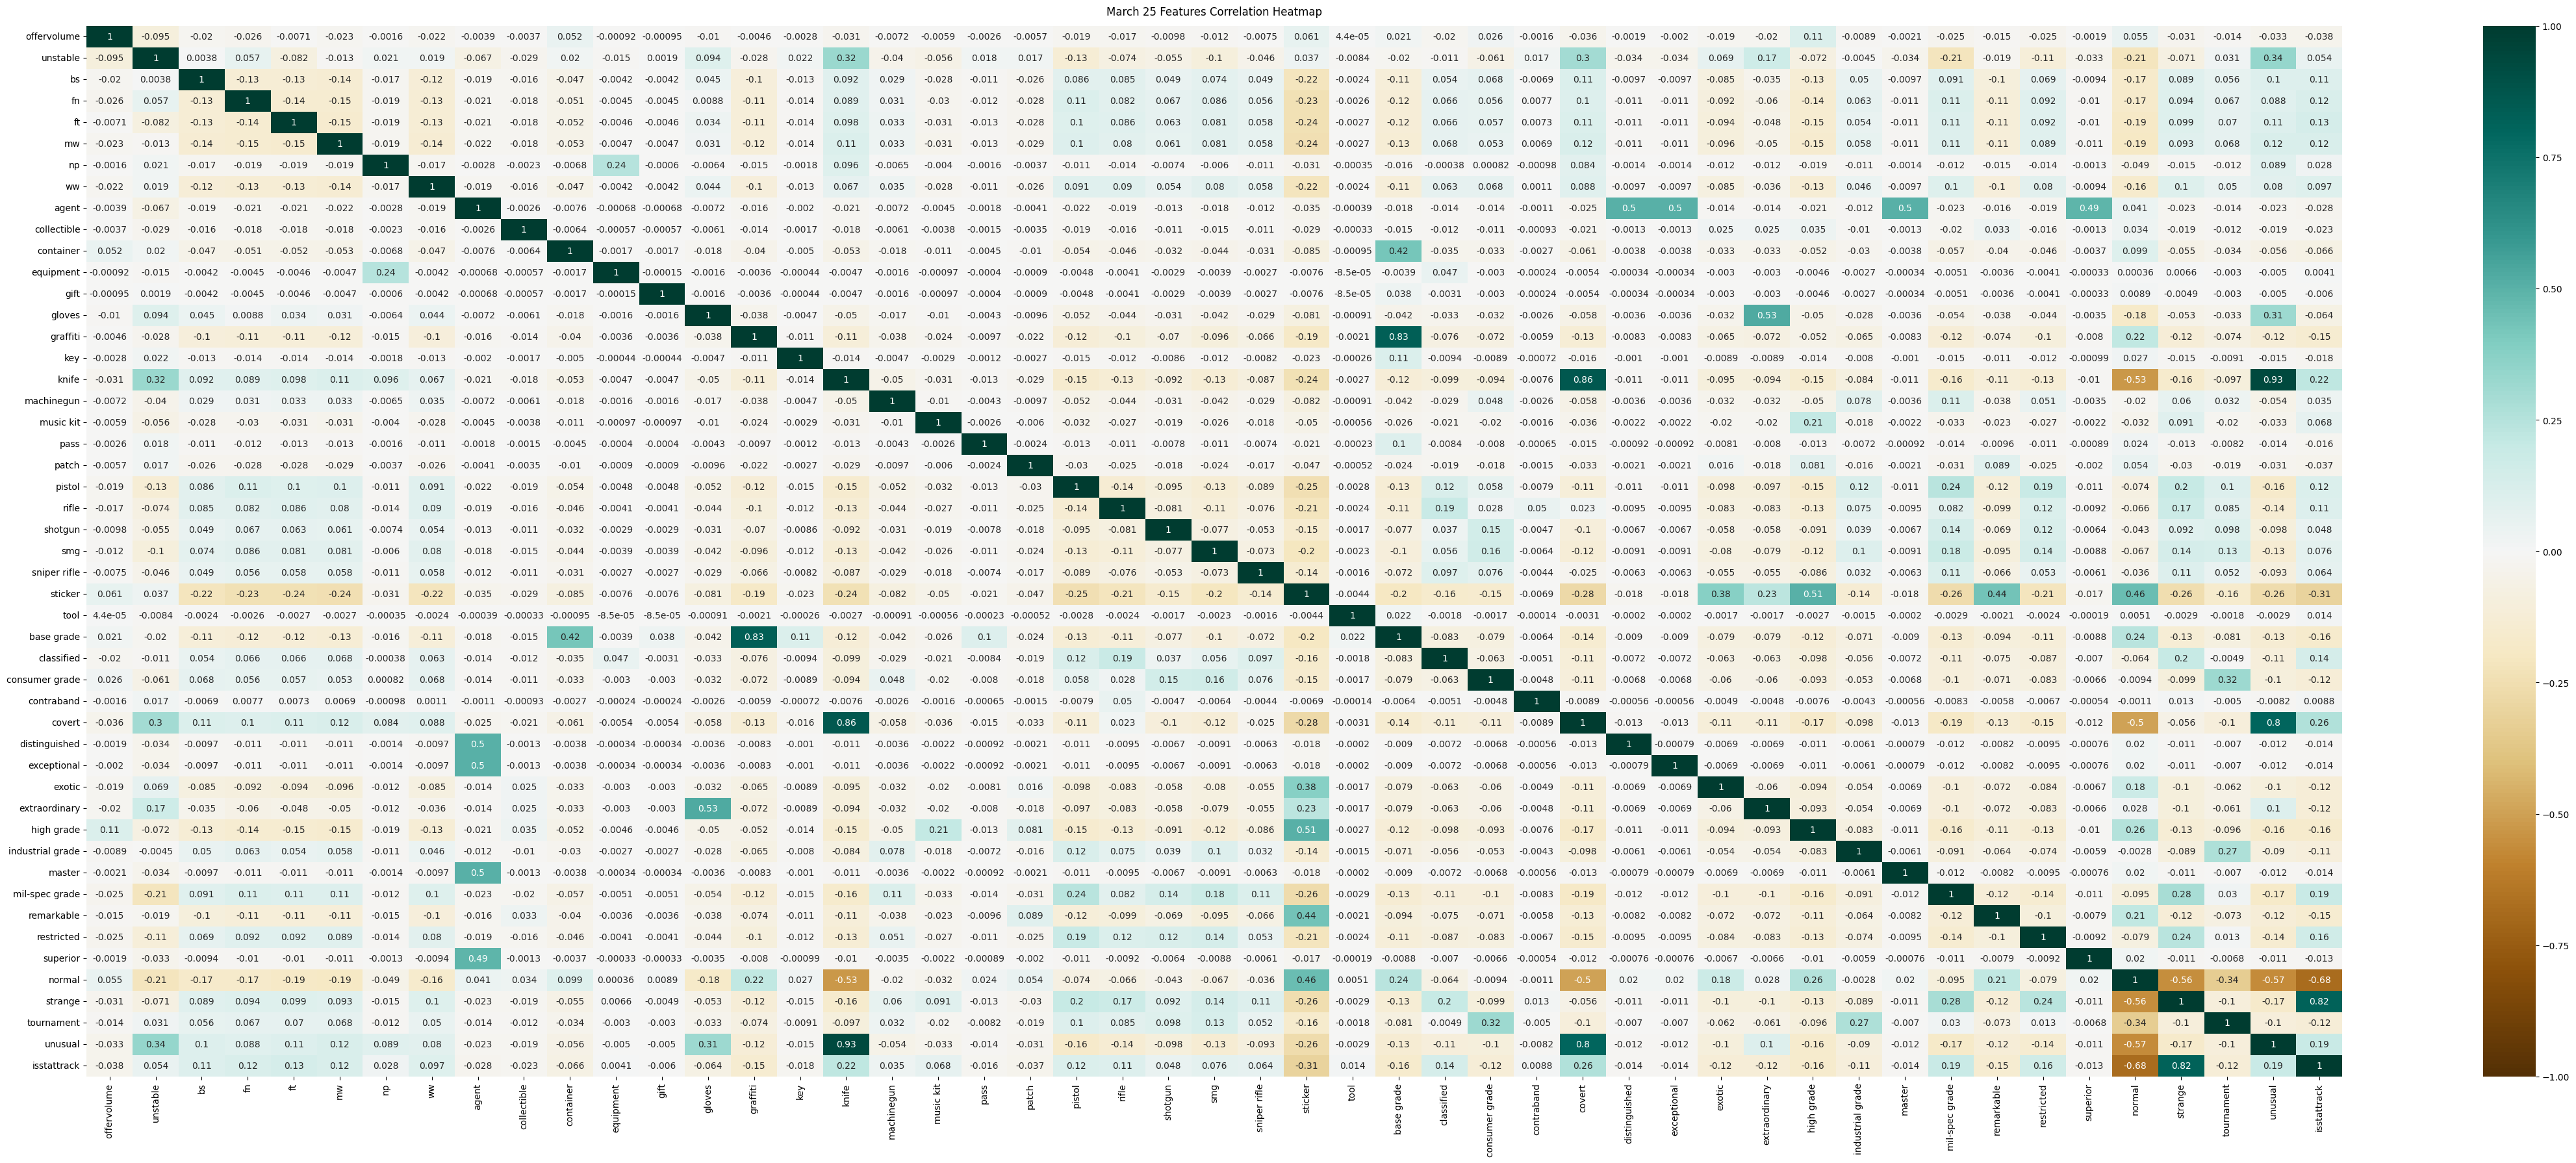

In [43]:
plotCorrelation(X_Mar25, "March 25")

### Train/Test Split

In [44]:
# splitting data into training and testing portions randomly
X_train, X_test, y_train, y_test, seed = data_split(X_Feb11, y_Feb11)

Seed: 3242


In [45]:
X_train

offervolume  unstable  bs  fn  ft  mw  np  ww  agent  collectible  ...  \
20125         24.0         1   0   0   0   0   0   0      0            0  ...   
15825         58.0         1   0   0   0   0   0   0      0            0  ...   
9482        3544.0         0   0   0   0   0   0   0      0            0  ...   
12220        144.0         0   0   0   1   0   0   0      0            0  ...   
12551          8.0         1   0   1   0   0   0   0      0            0  ...   
...            ...       ...  ..  ..  ..  ..  ..  ..    ...          ...  ...   
17110         46.0         1   0   0   0   0   0   0      0            0  ...   
12100          6.0         1   1   0   0   0   0   0      0            0  ...   
21041         27.0         1   0   0   0   0   0   0      0            0  ...   
19655         27.0         1   0   0   0   0   0   0      0            0  ...   
12500         63.0         0   0   0   1   0   0   0      0            0  ...   

       master  mil-spec grade  remarkable  restricted  superior  normal  \
20125       0               0           0           0         0       1   
15825       0               0           0           0         0       1   
9482        0               0           0           0         0       1   
12220       0               0           0           0         0       0   
12551       0               1           0           0         0       0   
...       ...             ...         ...         ...       ...     ...   
17110       0               0           1           0         0       1   
12100       0               0           0           0         0       0   
21041       0               0           0           0         0       1   
19655       0               0           0           0         0       1   
12500       0               0           0           1         0       0   

       strange  tournament  unusual  isstattrack  
20125        0           0        0            0  
15825        0           0        0            0  
9482         0           0        0            0  
12220        1           0        0            1  
12551        1           0        0            1  
...        ...         ...      ...          ...  
17110        0           0        0            0  
12100        1           0        0            1  
21041        0           0        0            0  
19655        0           0        0            0  
12500        1           0        0            1  

[16116 rows x 49 columns]

### Linear Models

#### OLS

In [46]:
print('Ordinary Least Squares')
reg = LinearRegression().fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))

Ordinary Least Squares
Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 239.28628533897074
Feb11 Test RMSE: 233.06131603972358
Mar25 RMSE: 237.0840801380444

RMSLE Scores
Feb11 Train RMSLE: 1.8901556276844367
Feb11 Test RMSLE: 1.8875857435677181
Mar25 RMSLE: 1.9053751038236006

MAPE Scores
Feb11 Train MAPE: 22800616693278.527
Feb11 Test MAPE: 672622360615895.5
Mar25 MAPE: 37326568908405.04

R-Squared: 0.34550505512747287


In [47]:
show_coefs(reg, X_Feb11)

           Variables  Coefficients
0          intercept    121.135994
1        offervolume      0.000033
2           unstable     65.791148
3                 bs     76.095053
4                 fn    205.408439
5                 ft    100.073583
6                 mw    154.748854
7                 np    218.119012
8                 ww     82.737270
9              agent    -68.705534
10       collectible    -90.969493
11         container    -48.293097
12         equipment    126.673570
13              gift     18.792340
14            gloves     25.964657
15          graffiti   -119.160172
16               key   -135.895040
17             knife     94.664817
18        machinegun    101.195394
19         music kit    -46.044014
20              pass    -46.139843
21             patch   -105.456266
22            pistol     77.154945
23             rifle    105.694499
24           shotgun     84.247677
25               smg     82.298469
26      sniper rifle    139.288184
27           sticker

#### Ridge

In [48]:
print('Ridge Regression')
reg = RidgeCV(alphas=np.arange(0.001, 10, 0.001)).fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))
print("Alpha:", reg.alpha_)

Ridge Regression
Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 239.28654908199707
Feb11 Test RMSE: 233.05833338461966
Mar25 RMSE: 237.08245655047548

RMSLE Scores
Feb11 Train RMSLE: 1.8894777673644172
Feb11 Test RMSLE: 1.8869181465197506
Mar25 RMSLE: 1.9049768095282773

MAPE Scores
Feb11 Train MAPE: 22823840418927.527
Feb11 Test MAPE: 672688298526039.0
Mar25 MAPE: 37355385326746.88

R-Squared: 0.345499897892103
Alpha: 0.04


In [49]:
show_coefs(reg, X_Feb11)

           Variables  Coefficients
0          intercept    133.476784
1        offervolume      0.000017
2           unstable     65.804257
3                 bs     59.540251
4                 fn    188.850309
5                 ft     83.542146
6                 mw    138.202786
7                 np    201.346900
8                 ww     66.193108
9              agent    -77.587934
10       collectible    -80.452377
11         container    -37.751961
12         equipment    110.704126
13              gift     28.201811
14            gloves     48.390155
15          graffiti   -108.622825
16               key   -125.106629
17             knife     75.648306
18        machinegun     86.683876
19         music kit    -35.594294
20              pass    -35.521906
21             patch    -94.983914
22            pistol     62.659490
23             rifle     91.253354
24           shotgun     69.747223
25               smg     67.801367
26      sniper rifle    124.787605
27           sticker

#### LASSO

In [50]:
print('LASSO Regression')
reg = LassoCV(alphas=np.arange(0.001, 10, 0.001), max_iter=100000).fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))
print("Alpha:", reg.alpha_)

LASSO Regression
Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 239.28983478987416
Feb11 Test RMSE: 233.05285817423905
Mar25 RMSE: 237.08179696809157

RMSLE Scores
Feb11 Train RMSLE: 1.8902554041667856
Feb11 Test RMSLE: 1.8874802977444574
Mar25 RMSLE: 1.9053823021725613

MAPE Scores
Feb11 Train MAPE: 22791338542512.215
Feb11 Test MAPE: 672636777103887.6
Mar25 MAPE: 37316665401976.99

R-Squared: 0.34548896673688423
Alpha: 0.001


In [51]:
show_coefs(reg, X_Feb11)

           Variables  Coefficients
0          intercept     39.644304
1        offervolume      0.000033
2           unstable     65.797374
3                 bs     34.665547
4                 fn    163.977604
5                 ft     58.685212
6                 mw    113.335327
7                 np    176.254787
8                 ww     41.323842
9              agent     -5.987561
10       collectible    -44.442543
11         container     -1.686876
12         equipment     42.495373
13              gift     49.253871
14            gloves     97.425137
15          graffiti    -72.606759
16               key    -88.511404
17             knife     -0.000000
18        machinegun     22.338330
19         music kit      0.000000
20              pass      0.000000
21             patch    -59.152237
22            pistol     -1.626658
23             rifle     26.992842
24           shotgun      5.434230
25               smg      3.496685
26      sniper rifle     60.481765
27           sticker

#### Elastic Net

In [52]:
print('Elastic Net Regression')
reg = ElasticNetCV(alphas=np.arange(0.001, 10, 0.001), max_iter=100000, l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))
print("Alpha:", reg.alpha_)
print("L1 Ratio:", reg.l1_ratio_)

Elastic Net Regression
Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 239.28983478987416
Feb11 Test RMSE: 233.05285817423905
Mar25 RMSE: 237.08179696809157

RMSLE Scores
Feb11 Train RMSLE: 1.8902554041667856
Feb11 Test RMSLE: 1.8874802977444574
Mar25 RMSLE: 1.9053823021725613

MAPE Scores
Feb11 Train MAPE: 22791338542512.215
Feb11 Test MAPE: 672636777103887.6
Mar25 MAPE: 37316665401976.99

R-Squared: 0.34548896673688423
Alpha: 0.001
L1 Ratio: 1.0


In [53]:
show_coefs(reg, X_Feb11)

           Variables  Coefficients
0          intercept     39.644304
1        offervolume      0.000033
2           unstable     65.797374
3                 bs     34.665547
4                 fn    163.977604
5                 ft     58.685212
6                 mw    113.335327
7                 np    176.254787
8                 ww     41.323842
9              agent     -5.987561
10       collectible    -44.442543
11         container     -1.686876
12         equipment     42.495373
13              gift     49.253871
14            gloves     97.425137
15          graffiti    -72.606759
16               key    -88.511404
17             knife     -0.000000
18        machinegun     22.338330
19         music kit      0.000000
20              pass      0.000000
21             patch    -59.152237
22            pistol     -1.626658
23             rifle     26.992842
24           shotgun      5.434230
25               smg      3.496685
26      sniper rifle     60.481765
27           sticker

### Non-Linear Models

#### Polynomial Regression

In [54]:
# initializing a polynomial transformer of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_Feb11)

# splitting the polynomially transformed data with the same seed (state) as before
poly_X_train, poly_X_test, poly_y_train, poly_y_test, _ = data_split(poly_features, y_Feb11, state=seed, test_size=0.2)

Seed: 3242


In [55]:
# fitting validation data to a polynomial degree
poly_X_Mar25 = poly.fit_transform(X_Mar25)

In [56]:
print('Polynomial Regression with no Regularization')
reg = LinearRegression().fit(poly_X_train, poly_y_train)
true_vals = [poly_y_train, poly_y_test, y_Mar25]
pred_vals = [reg.predict(poly_X_train), reg.predict(poly_X_test), reg.predict(poly_X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(poly_X_train, poly_y_train))

Polynomial Regression with no Regularization
Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 210.15687773048248
Feb11 Test RMSE: 203.906696189174
Mar25 RMSE: 209.6575522045086

RMSLE Scores
Feb11 Train RMSLE: 1.580831022657523
Feb11 Test RMSLE: 1.5929656643526242
Mar25 RMSLE: 1.5750870282159124

MAPE Scores
Feb11 Train MAPE: 35369444683355.164
Feb11 Test MAPE: 957210049468510.2
Mar25 MAPE: 50951230755536.19

R-Squared: 0.48708691502191415


#### Kernel Ridge

##### Cosine

In [57]:
print('Kernel Ridge with the Cosine Kernel')
reg = KernelRidge(alpha=1.0, kernel='cosine').fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Cosine Kernel
Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 173.46357147598306
Feb11 Test RMSE: 176.3714499783822
Mar25 RMSE: 172.89955475001182

RMSLE Scores
Feb11 Train RMSLE: 1.2541957984648513
Feb11 Test RMSLE: 1.265172768516076
Mar25 RMSLE: 1.233400004228713

MAPE Scores
Feb11 Train MAPE: 202911649995682.4
Feb11 Test MAPE: 1381012337668935.8
Mar25 MAPE: 453727149835505.56

R-Squared: 0.6581898021866468


##### RBF

In [58]:
print('Kernel Ridge with the RBF Kernel')
reg = KernelRidge(alpha=1.0, kernel='rbf').fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the RBF Kernel
Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 169.1029452414221
Feb11 Test RMSE: 174.899587226966
Mar25 RMSE: 170.32805813298998

RMSLE Scores
Feb11 Train RMSLE: 0.948361284099262
Feb11 Test RMSLE: 0.9880712101051027
Mar25 RMSLE: 0.9672163934153198

MAPE Scores
Feb11 Train MAPE: 1030572195362416.4
Feb11 Test MAPE: 1939215557017327.0
Mar25 MAPE: 705348665912304.4

R-Squared: 0.675714046617349


##### Laplacian

In [59]:
print('Kernel Ridge with the Laplacian Kernel')
reg = KernelRidge(alpha=1.0, kernel='laplacian').fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Laplacian Kernel
Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 170.55784935212512
Feb11 Test RMSE: 174.7498647800101
Mar25 RMSE: 171.80182742126888

RMSLE Scores
Feb11 Train RMSLE: 0.987835257722722
Feb11 Test RMSLE: 1.0132905363402878
Mar25 RMSLE: 0.9836189878536592

MAPE Scores
Feb11 Train MAPE: 987269011502098.4
Feb11 Test MAPE: 1973568771185254.8
Mar25 MAPE: 663352357091948.9

R-Squared: 0.6695901371690406


##### Polynomial

In [60]:
print('Kernel Ridge with the Polynomial Kernel (Degree 2)')
reg = KernelRidge(alpha=1.0, kernel='polynomial', degree=2).fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Polynomial Kernel (Degree 2)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 315.73341054360174
Feb11 Test RMSE: 315.97421884643273
Mar25 RMSE: 316.1574579761266

RMSLE Scores
Feb11 Train RMSLE: 3.099700634973022
Feb11 Test RMSLE: 3.1188002137232984
Mar25 RMSLE: 3.094624620326243

MAPE Scores
Feb11 Train MAPE: 6.926149452207255
Feb11 Test MAPE: 5.659870472695898
Mar25 MAPE: 5.986991787072592

R-Squared: -0.13281150435139444


In [61]:
print('Kernel Ridge with the Polynomial Kernel (Degree 3)')
reg = KernelRidge(alpha=1.0, kernel='polynomial', degree=3).fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Polynomial Kernel (Degree 3)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 315.77653466911175
Feb11 Test RMSE: 315.967440767661
Mar25 RMSE: 316.15921196294914

RMSLE Scores
Feb11 Train RMSLE: 3.0930116499639206
Feb11 Test RMSLE: 3.1144558030290885
Mar25 RMSLE: 3.0889410596852387

MAPE Scores
Feb11 Train MAPE: 3.1067645289690415
Feb11 Test MAPE: 1.356730840492174
Mar25 MAPE: 1.9268484167834328

R-Squared: -0.1294559947630065


##### Sigmoid

In [62]:
print('Kernel Ridge with the Sigmoid Kernel')
reg = KernelRidge(alpha=1.0, kernel='sigmoid').fit(X_train, y_train)
true_vals = [y_train, y_test, y_Mar25]
pred_vals = [reg.predict(X_train), reg.predict(X_test), reg.predict(X_Mar25)]
pretty_print(true_vals, pred_vals, 2)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Sigmoid Kernel


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model trained on Feb11 data:

RMSE Scores
Feb11 Train RMSE: 305.4846291531767
Feb11 Test RMSE: 304.33874508361595
Mar25 RMSE: 300.89514843518356

RMSLE Scores
Feb11 Train RMSLE: 2.8688394782536726
Feb11 Test RMSLE: 2.8917559384324076
Mar25 RMSLE: 2.8693288298640005

MAPE Scores
Feb11 Train MAPE: 1243522814117097.2
Feb11 Test MAPE: 1080328009359742.8
Mar25 MAPE: 851524258542459.5

R-Squared: -0.6559091356644657


## March 25 Models

### Reading Main (March 25) Data

In [63]:
# reading the data
data_Mar25 = pd.read_csv("ItemFeatures_Mar25.csv", index_col=0)

# useful columns contained in this dataset
data_Mar25.columns

Index(['markethashname', 'color', 'bordercolor', 'pricelatest',
       'pricelatestsell', 'unstable', 'unstablereason', 'offervolume',
       'sold24h', 'sold7d', 'sold30d', 'sold90d', 'wear', 'itemgroup',
       'itemtype', 'rarity', 'quality', 'isstattrack', 'isstar'],
      dtype='object')

In [64]:
data_Mar25, X_Mar25, y_Mar25 = dataProcessing(data_Mar25, old=False)

Number of rows with missing values: 2067


### Feature Space Correlation/Heatmap

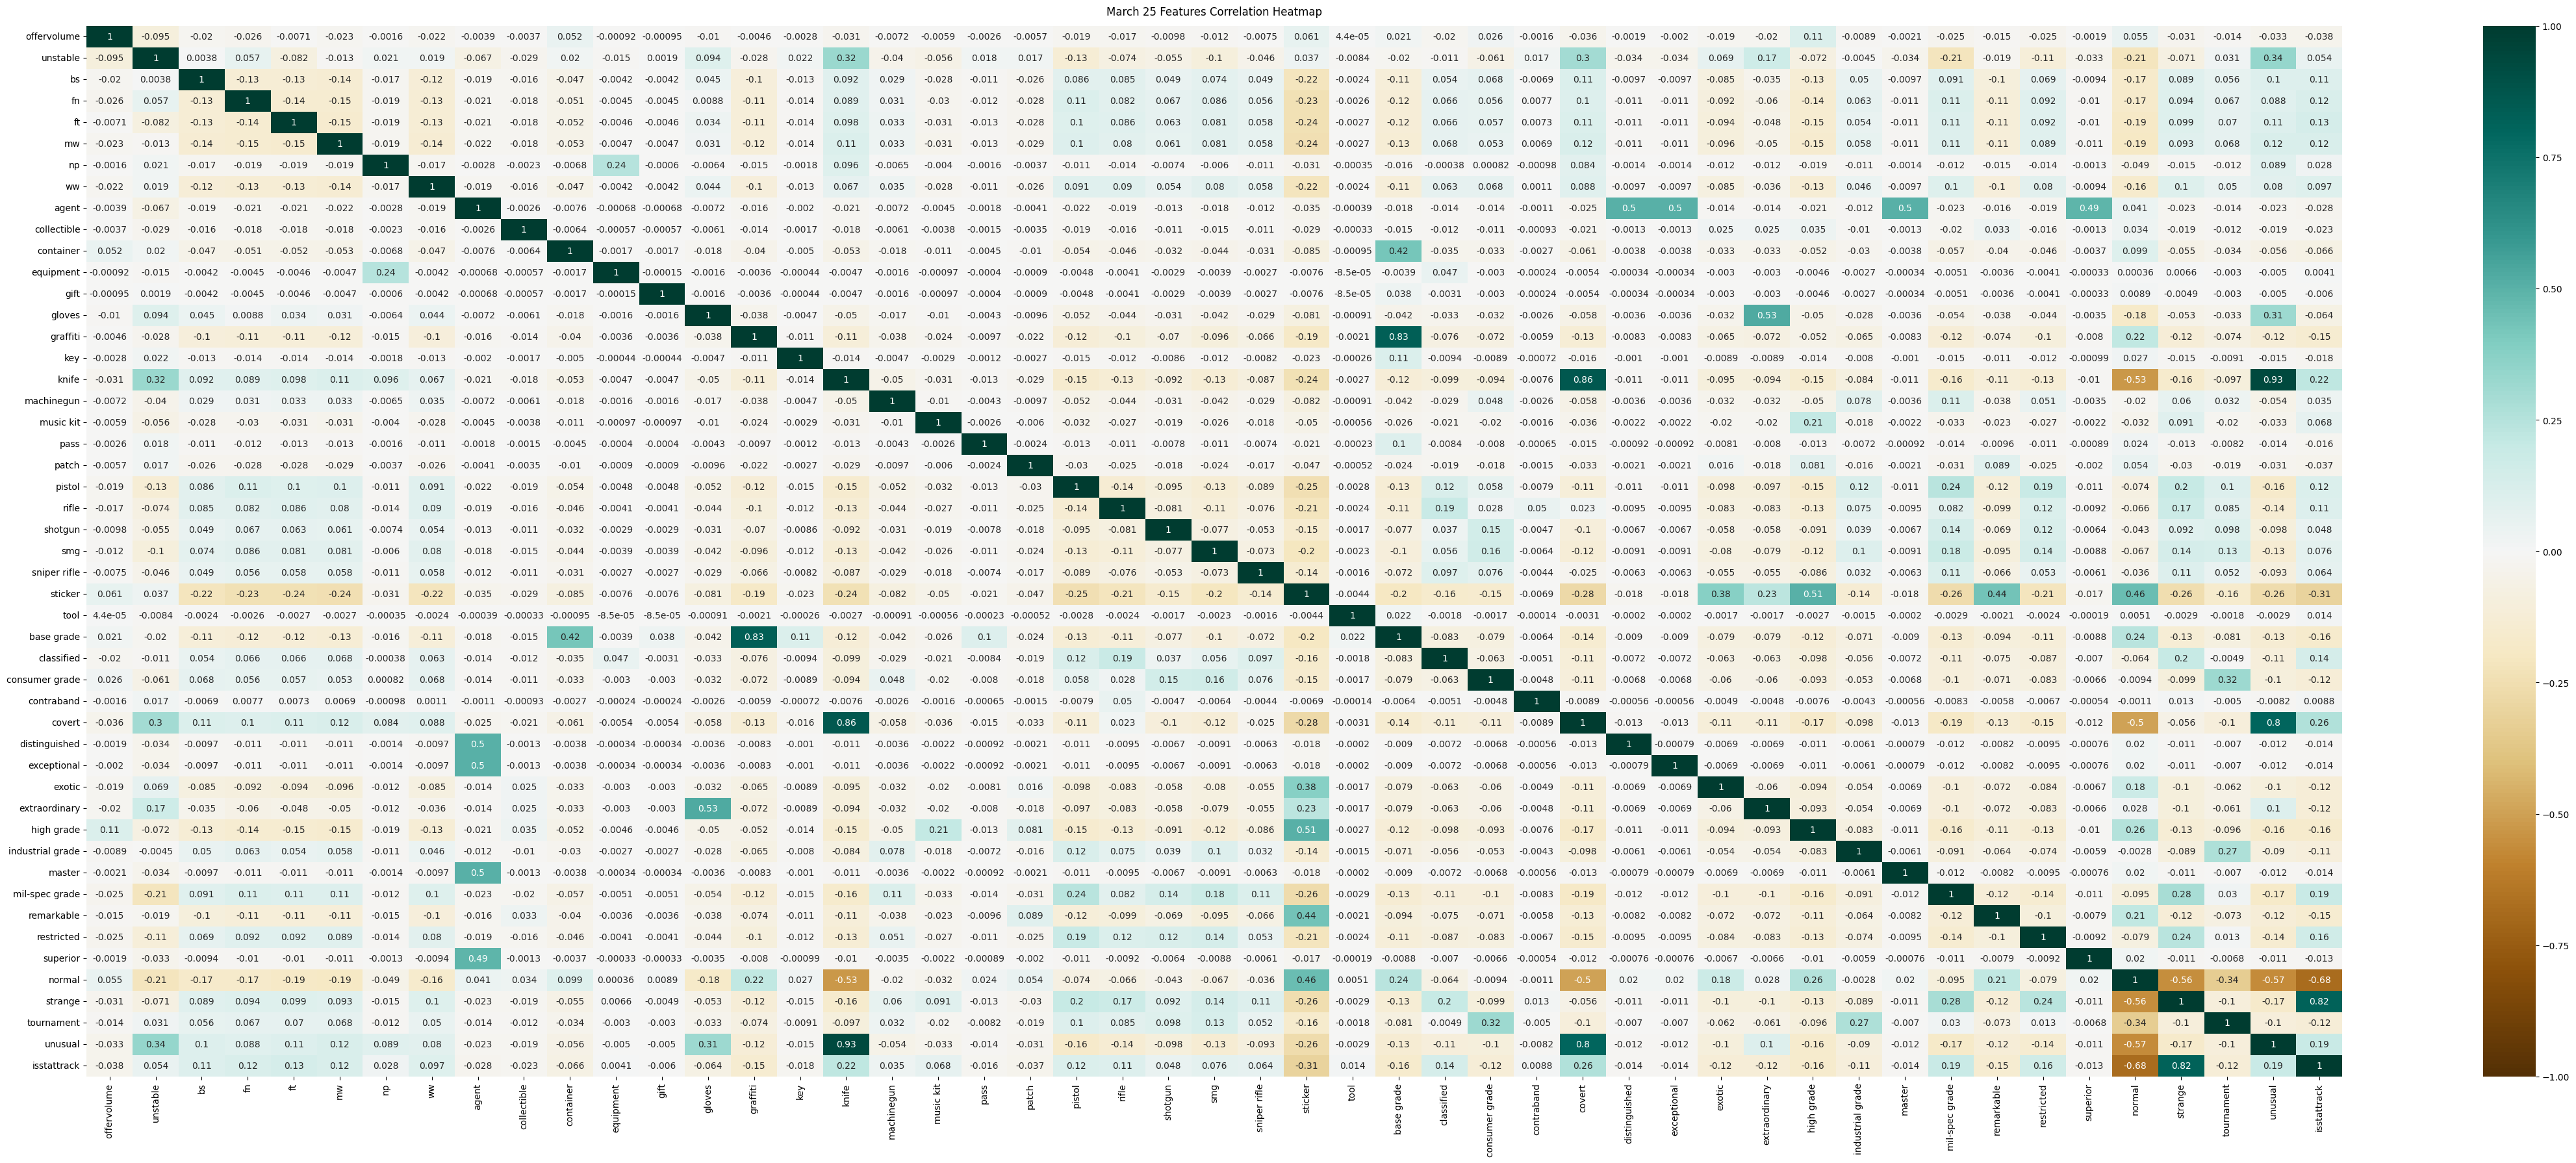

In [65]:
plotCorrelation(X_Mar25, "March 25")

### Train/Test Split

In [66]:
# splitting data into training and testing portions randomly
X_train, X_test, y_train, y_test, seed = data_split(X_Mar25, y_Mar25)

Seed: 5834


In [67]:
X_train

offervolume  unstable  bs  fn  ft  mw  np  ww  agent  collectible  ...  \
7176        1643.0         0   1   0   0   0   0   0      0            0  ...   
21877        127.0         0   0   1   0   0   0   0      0            0  ...   
7255           3.0         1   1   0   0   0   0   0      0            0  ...   
21324        147.0         1   0   0   0   0   0   0      0            0  ...   
21276         62.0         0   0   0   0   0   0   0      0            0  ...   
...            ...       ...  ..  ..  ..  ..  ..  ..    ...          ...  ...   
15745      43583.0         0   0   0   0   0   0   0      0            0  ...   
9929           8.0         1   0   0   0   0   0   0      0            0  ...   
19278         15.0         1   0   0   0   0   0   0      0            0  ...   
4690         447.0         0   0   0   1   0   0   0      0            0  ...   
110           12.0         1   0   0   0   0   0   1      0            0  ...   

       master  mil-spec grade  remarkable  restricted  superior  normal  \
7176        0               1           0           0         0       1   
21877       0               1           0           0         0       1   
7255        0               1           0           0         0       1   
21324       0               0           1           0         0       1   
21276       0               0           0           0         0       1   
...       ...             ...         ...         ...       ...     ...   
15745       0               0           0           0         0       1   
9929        0               0           0           0         0       1   
19278       0               0           0           0         0       1   
4690        0               1           0           0         0       1   
110         0               0           0           0         0       0   

       strange  tournament  unusual  isstattrack  
7176         0           0        0            0  
21877        0           0        0            0  
7255         0           0        0            0  
21324        0           0        0            0  
21276        0           0        0            0  
...        ...         ...      ...          ...  
15745        0           0        0            0  
9929         0           0        0            0  
19278        0           0        0            0  
4690         0           0        0            0  
110          0           0        1            0  

[16301 rows x 49 columns]

### Linear Models

#### OLS

In [68]:
print('Ordinary Least Squares')
reg = LinearRegression().fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))

Ordinary Least Squares
Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 238.84738856035477
Mar25 Test RMSE: 229.434189555179

RMSLE Scores
Mar25 Train RMSLE: 1.8949541323784995
Mar25 Test RMSLE: 1.8836041062038136

MAPE Scores
Mar25 Train MAPE: 30735731633221.746
Mar25 Test MAPE: 49763470831486.266

R-Squared: 0.35189128477519804


In [69]:
show_coefs(reg, X_Mar25)

           Variables  Coefficients
0          intercept    152.833557
1        offervolume      0.000035
2           unstable     61.716307
3                 bs     15.250318
4                 fn    151.702735
5                 ft     42.829985
6                 mw     93.318019
7                 np    172.200732
8                 ww     26.845985
9              agent    -87.124690
10       collectible    -63.085161
11         container     14.159826
12         equipment    -98.229813
13              gift     -2.994008
14            gloves     91.645506
15          graffiti    -74.630390
16               key    -89.547944
17             knife     55.967224
18        machinegun     84.057862
19         music kit     -9.630075
20              pass     -3.470008
21             patch    -67.321751
22            pistol     55.421958
23             rifle     87.974862
24           shotgun     56.493036
25               smg     59.089459
26      sniper rifle    109.727679
27           sticker

#### Ridge

In [70]:
print('Ridge Regression')
reg = RidgeCV(alphas=np.arange(0.001, 10, 0.001)).fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))
print("Alpha:", reg.alpha_)

Ridge Regression
Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 238.90278053259985
Mar25 Test RMSE: 229.44369284998209

RMSLE Scores
Mar25 Train RMSLE: 1.899303489787023
Mar25 Test RMSLE: 1.8847275722702879

MAPE Scores
Mar25 Train MAPE: 30525165023867.074
Mar25 Test MAPE: 49342566515322.27

R-Squared: 0.3516095082845345
Alpha: 0.017


In [71]:
show_coefs(reg, X_Mar25)

           Variables  Coefficients
0          intercept    152.185582
1        offervolume      0.000206
2           unstable     61.720842
3                 bs     15.035213
4                 fn    151.493515
5                 ft     42.615612
6                 mw     93.106109
7                 np    171.870240
8                 ww     26.634656
9              agent    -86.900453
10       collectible    -63.087326
11         container     14.148952
12         equipment    -97.603408
13              gift     -2.987155
14            gloves     91.870678
15          graffiti    -74.640887
16               key    -89.483242
17             knife     55.700891
18        machinegun     83.720247
19         music kit     -9.663400
20              pass     -3.477805
21             patch    -67.342714
22            pistol     55.091392
23             rifle     87.662066
24           shotgun     56.160539
25               smg     58.757934
26      sniper rifle    109.395005
27           sticker

#### LASSO

In [72]:
print('LASSO Regression')
reg = LassoCV(alphas=np.arange(0.001, 10, 0.001), max_iter=100000).fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))
print("Alpha:", reg.alpha_)

LASSO Regression
Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 238.84983441317752
Mar25 Test RMSE: 229.44798235769824

RMSLE Scores
Mar25 Train RMSLE: 1.8948152666209996
Mar25 Test RMSLE: 1.8832965103924248

MAPE Scores
Mar25 Train MAPE: 30733819135224.78
Mar25 Test MAPE: 49796247108974.91

R-Squared: 0.351889674309948
Alpha: 0.002


In [73]:
show_coefs(reg, X_Mar25)

           Variables  Coefficients
0          intercept     21.863010
1        offervolume      0.000035
2           unstable     61.727466
3                 bs    -27.581571
4                 fn    108.843285
5                 ft     -0.000000
6                 mw     50.456736
7                 np    127.677157
8                 ww    -15.981554
9              agent     12.429682
10       collectible    -16.481949
11         container     59.670271
12         equipment   -148.477318
13              gift     31.755000
14            gloves    192.283035
15          graffiti    -28.980187
16               key    -42.304662
17             knife      0.000000
18        machinegun     15.581929
19         music kit     35.727281
20              pass     40.332632
21             patch    -21.259793
22            pistol    -12.889565
23             rifle     19.664121
24           shotgun    -11.803671
25               smg     -9.221375
26      sniper rifle     41.362357
27           sticker

#### Elastic Net

In [74]:
print('Elastic Net Regression')
reg = ElasticNetCV(alphas=np.arange(0.001, 10, 0.001), max_iter=100000, l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))
print("Alpha:", reg.alpha_)
print("L1 Ratio:", reg.l1_ratio_)

Elastic Net Regression
Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 238.85110959205778
Mar25 Test RMSE: 229.45884753804634

RMSLE Scores
Mar25 Train RMSLE: 1.8950809870106782
Mar25 Test RMSLE: 1.8836193412128066

MAPE Scores
Mar25 Train MAPE: 30754923863760.75
Mar25 Test MAPE: 49805745977377.54

R-Squared: 0.3518752613458972
Alpha: 0.001
L1 Ratio: 0.99


In [75]:
show_coefs(reg, X_Mar25)

           Variables  Coefficients
0          intercept    112.436768
1        offervolume      0.000035
2           unstable     61.773445
3                 bs     -0.000000
4                 fn    136.501100
5                 ft     27.577737
6                 mw     78.089280
7                 np    154.995333
8                 ww     11.621174
9              agent    -75.661695
10       collectible    -52.878317
11         container     23.575651
12         equipment   -117.723370
13              gift      1.050868
14            gloves     99.351268
15          graffiti    -65.118682
16               key    -78.635017
17             knife      0.000000
18        machinegun     44.691111
19         music kit     -0.000000
20              pass      5.056257
21             patch    -57.542732
22            pistol     16.164762
23             rifle     48.907184
24           shotgun     17.205142
25               smg     19.818827
26      sniper rifle     70.444050
27           sticker

### Non-Linear Models

#### Polynomial Regression

In [76]:
# initializing a polynomial transformer of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_Mar25)

# splitting the polynomially transformed data with the same seed (state) as before
poly_X_train, poly_X_test, poly_y_train, poly_y_test, _ = data_split(poly_features, y_Mar25, state=seed, test_size=0.2)

Seed: 5834


In [77]:
print('Polynomial Regression with no Regularization')
reg = LinearRegression().fit(poly_X_train, poly_y_train)
true_vals = [poly_y_train, poly_y_test]
pred_vals = [reg.predict(poly_X_train), reg.predict(poly_X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(poly_X_train, poly_y_train))

Polynomial Regression with no Regularization
Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 211.54964018739142
Mar25 Test RMSE: 228.49550845474843

RMSLE Scores
Mar25 Train RMSLE: 1.5927204040753324
Mar25 Test RMSLE: 1.5953039859473483

MAPE Scores
Mar25 Train MAPE: 43243663487523.7
Mar25 Test MAPE: 59582069113608.78

R-Squared: 0.48414879034232106


#### Kernel Ridge

##### Cosine

In [78]:
print('Kernel Ridge with the Cosine Kernel')
reg = KernelRidge(alpha=1.0, kernel='cosine').fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Cosine Kernel
Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 171.44916587081704
Mar25 Test RMSE: 175.6959023681967

RMSLE Scores
Mar25 Train RMSLE: 1.2558670510651364
Mar25 Test RMSLE: 1.2439728056503496

MAPE Scores
Mar25 Train MAPE: 471806229521359.7
Mar25 Test MAPE: 425922663720463.75

R-Squared: 0.6678672138189437


##### RBF

In [79]:
print('Kernel Ridge with the RBF Kernel')
reg = KernelRidge(alpha=1.0, kernel='rbf').fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the RBF Kernel
Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 167.98562547384233
Mar25 Test RMSE: 175.07362828487896

RMSLE Scores
Mar25 Train RMSLE: 0.922843987505937
Mar25 Test RMSLE: 0.9455800979410626

MAPE Scores
Mar25 Train MAPE: 648331847505744.0
Mar25 Test MAPE: 1077488653665745.6

R-Squared: 0.6820598224115355


##### Laplacian

In [80]:
print('Kernel Ridge with the Laplacian Kernel')
reg = KernelRidge(alpha=1.0, kernel='laplacian').fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Laplacian Kernel
Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 169.89083428540096
Mar25 Test RMSE: 176.0275699922888

RMSLE Scores
Mar25 Train RMSLE: 0.9718172660542735
Mar25 Test RMSLE: 0.9733383420136618

MAPE Scores
Mar25 Train MAPE: 599441517855888.2
Mar25 Test MAPE: 1059285679684771.6

R-Squared: 0.6741887958872771


##### Polynomial

In [81]:
print('Kernel Ridge with the Polynomial Kernel (Degree 2)')
reg = KernelRidge(alpha=1.0, kernel='polynomial', degree=2).fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Polynomial Kernel (Degree 2)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 316.97147566564024
Mar25 Test RMSE: 313.88695248752424

RMSLE Scores
Mar25 Train RMSLE: 3.1705276247002496
Mar25 Test RMSLE: 3.1961849700344622

MAPE Scores
Mar25 Train MAPE: 815645929.6166265
Mar25 Test MAPE: 1628554864.1861837

R-Squared: -0.13266777627210136


In [82]:
print('Kernel Ridge with the Polynomial Kernel (Degree 3)')
reg = KernelRidge(alpha=1.0, kernel='polynomial', degree=3).fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Polynomial Kernel (Degree 3)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 318.6683823937256
Mar25 Test RMSE: 313.6270505404827

RMSLE Scores
Mar25 Train RMSLE: 3.092395176481656
Mar25 Test RMSLE: 3.101448525448854

MAPE Scores
Mar25 Train MAPE: 15.139108925405795
Mar25 Test MAPE: 3.059496676276839

R-Squared: -0.1430209903419084


##### Sigmoid

In [83]:
print('Kernel Ridge with the Sigmoid Kernel')
reg = KernelRidge(alpha=1.0, kernel='sigmoid').fit(X_train, y_train)
true_vals = [y_train, y_test]
pred_vals = [reg.predict(X_train), reg.predict(X_test)]
pretty_print(true_vals, pred_vals, 3)
print("\nR-Squared:", reg.score(X_train, y_train))

Kernel Ridge with the Sigmoid Kernel


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model trained on Mar25 data:

RMSE Scores
Mar25 Train RMSE: 352.112236259495
Mar25 Test RMSE: 339.07644537162815

RMSLE Scores
Mar25 Train RMSLE: 3.015623677559118
Mar25 Test RMSLE: 3.043845960393552

MAPE Scores
Mar25 Train MAPE: 400350511313058.25
Mar25 Test MAPE: 1601107380988146.2

R-Squared: -1.6260994024832716


# Kernel Visualization

## Cosine Kernel

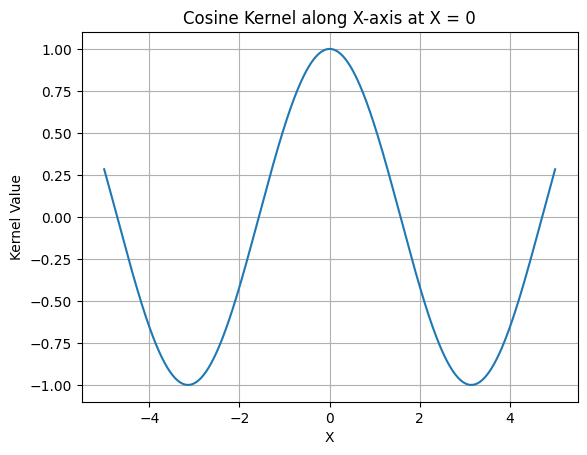

In [ ]:
def cosine_kernel_visualization_1d(omega=1.0, axis='x', slice_value=0):
    if axis.lower() == 'x':
        x = np.linspace(-5, 5, 1000)
        y = np.cos(omega * np.abs(x - slice_value))
        plt.plot(x, y)
        plt.title('Cosine Kernel along X-axis at X = {}'.format(slice_value))
        plt.xlabel('X')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    elif axis.lower() == 'y':
        y = np.linspace(-5, 5, 1000)
        x = np.cos(omega * np.abs(y - slice_value))
        plt.plot(y, x)
        plt.title('Cosine Kernel along Y-axis at Y = {}'.format(slice_value))
        plt.xlabel('Y')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    else:
        print("Invalid axis. Please choose 'x' or 'y'.")

# example usage
cosine_kernel_visualization_1d(omega=1.0, axis='x', slice_value=0)

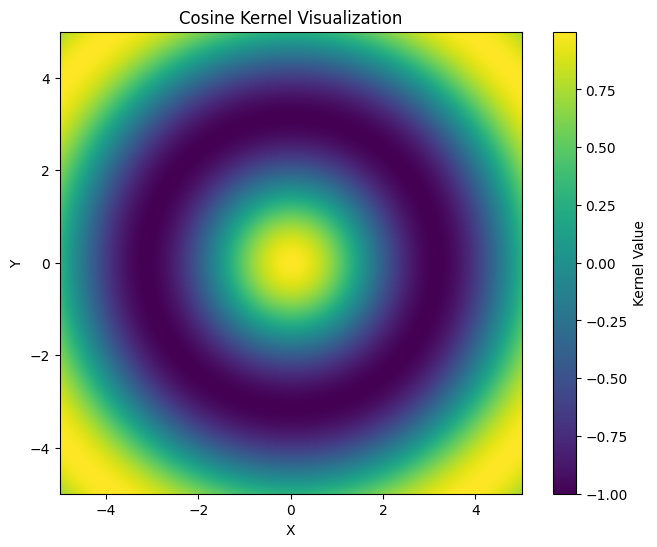

In [ ]:
def cosine_kernel_visualization_2d(omega=1.0):
    x = np.linspace(-5, 5, 1000)
    y = np.linspace(-5, 5, 1000)
    X, Y = np.meshgrid(x, y)
    Z = np.cos(omega * np.sqrt(X**2 + Y**2))

    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=(-5, 5, -5, 5), cmap='viridis', origin='lower')
    plt.title('Cosine Kernel Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Kernel Value')
    plt.show()

# example usage
cosine_kernel_visualization_2d(omega=1.0)

## RBF Kernel

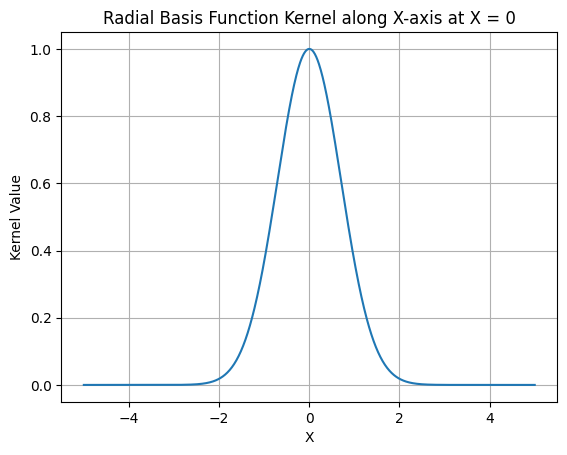

In [ ]:
def rbf_kernel_visualization_1d(gamma=1.0, axis='x', slice_value=0):
    if axis.lower() == 'x':
        x = np.linspace(-5, 5, 1000)
        y = np.exp(-gamma * (x - slice_value)**2)
        plt.plot(x, y)
        plt.title('Radial Basis Function Kernel along X-axis at X = {}'.format(slice_value))
        plt.xlabel('X')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    elif axis.lower() == 'y':
        y = np.linspace(-5, 5, 1000)
        x = np.exp(-gamma * (y - slice_value)**2)
        plt.plot(y, x)
        plt.title('Radial Basis Function Kernel along Y-axis at Y = {}'.format(slice_value))
        plt.xlabel('Y')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    else:
        print("Invalid axis. Please choose 'x' or 'y'.")

# example usage
rbf_kernel_visualization_1d(gamma=1.0, axis='x', slice_value=0)

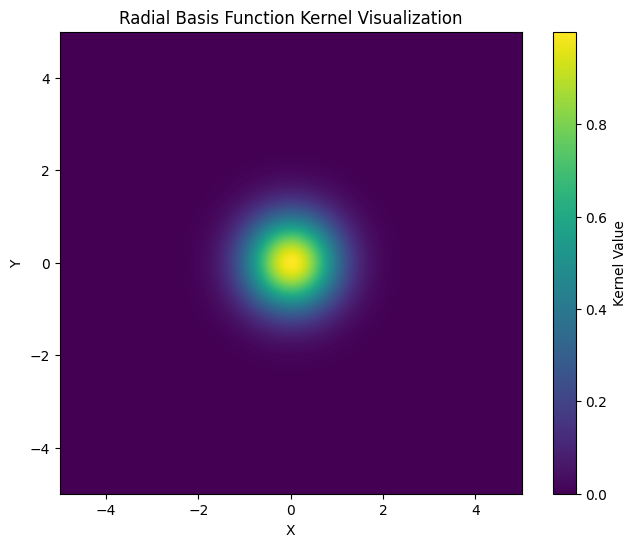

In [ ]:
def rbf_kernel_visualization_2d(gamma=1.0):
    x = np.linspace(-5, 5, 1000)
    y = np.linspace(-5, 5, 1000)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(-gamma * (X**2 + Y**2))

    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=(-5, 5, -5, 5), cmap='viridis', origin='lower')
    plt.title('Radial Basis Function Kernel Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Kernel Value')
    plt.show()

# example usage
rbf_kernel_visualization_2d(gamma=1)

## Laplacian Kernel

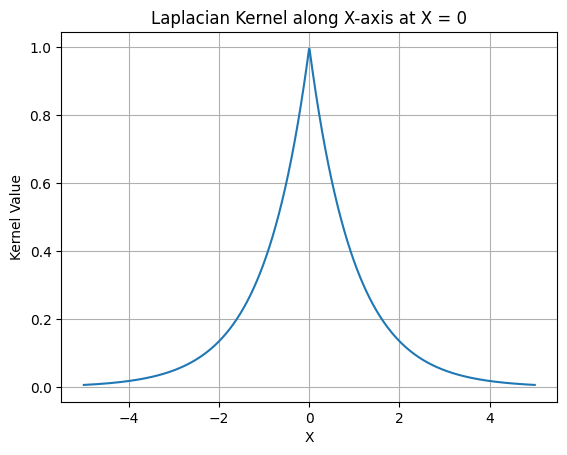

In [ ]:
def laplacian_kernel_visualization_1d(gamma=1.0, axis='x', slice_value=0):
    if axis.lower() == 'x':
        x = np.linspace(-5, 5, 1000)
        y = np.exp(-gamma * np.abs(x - slice_value))
        plt.plot(x, y)
        plt.title('Laplacian Kernel along X-axis at X = {}'.format(slice_value))
        plt.xlabel('X')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    elif axis.lower() == 'y':
        y = np.linspace(-5, 5, 1000)
        x = np.exp(-gamma * np.abs(y - slice_value))
        plt.plot(y, x)
        plt.title('Laplacian Kernel along Y-axis at Y = {}'.format(slice_value))
        plt.xlabel('Y')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    else:
        print("Invalid axis. Please choose 'x' or 'y'.")

# example usage
laplacian_kernel_visualization_1d(gamma=1.0, axis='x', slice_value=0)

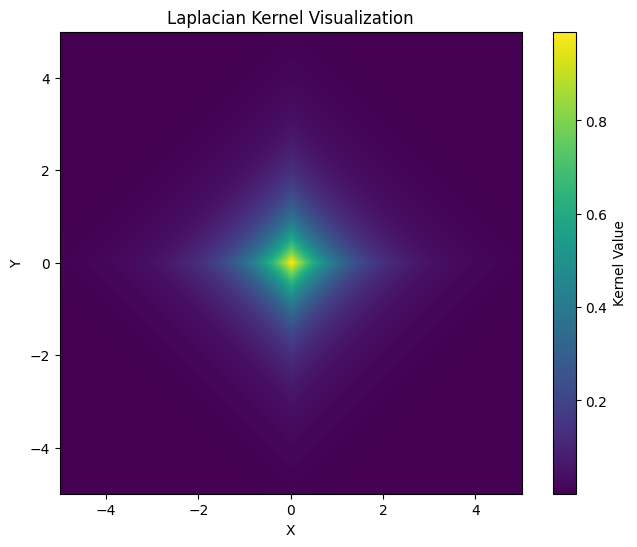

In [ ]:
def laplacian_kernel_visualization_2d(gamma=1.0):
    x = np.linspace(-5, 5, 1000)
    y = np.linspace(-5, 5, 1000)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(-gamma * (np.abs(X) + np.abs(Y)))

    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=(-5, 5, -5, 5), cmap='viridis', origin='lower')
    plt.title('Laplacian Kernel Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Kernel Value')
    plt.show()

# example usage
laplacian_kernel_visualization_2d(gamma=1.0)

## Polynomial Kernel

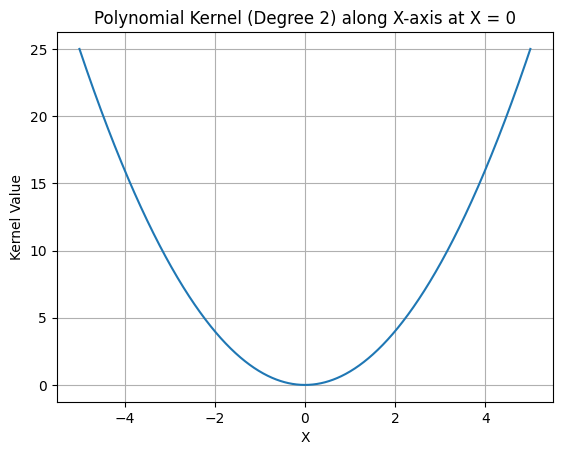

In [ ]:
def polynomial_kernel_visualization_1d(degree=2, bias=1.0, scale=1.0, axis='x', slice_value=0):
    if axis.lower() == 'x':
        x = np.linspace(-5, 5, 1000)
        y = (scale * x + bias) ** degree
        plt.plot(x, y)
        plt.title('Polynomial Kernel (Degree {}) along X-axis at X = {}'.format(degree, slice_value))
        plt.xlabel('X')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    elif axis.lower() == 'y':
        y = np.linspace(-5, 5, 1000)
        x = (scale * y + bias) ** degree
        plt.plot(y, x)
        plt.title('Polynomial Kernel (Degree {}) along Y-axis at Y = {}'.format(degree, slice_value))
        plt.xlabel('Y')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    else:
        print("Invalid axis. Please choose 'x' or 'y'.")

# example usage
polynomial_kernel_visualization_1d(degree=2, bias=0, scale=1.0, axis='x', slice_value=0)

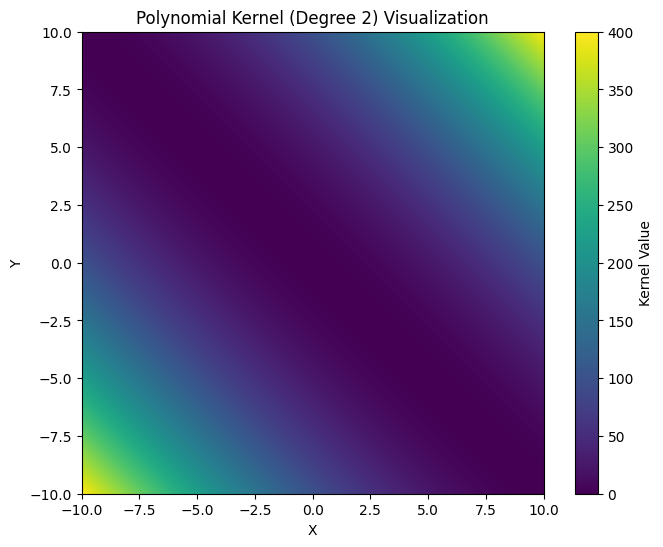

In [ ]:
def polynomial_kernel_visualization_2d(degree=2, bias=1.0, scale=1.0):
    x = np.linspace(-10, 10, 1000)
    y = np.linspace(-10, 10, 1000)
    X, Y = np.meshgrid(x, y)
    Z = (scale * (X + Y) + bias) ** degree

    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=(-10, 10, -10, 10), cmap='viridis', origin='lower')
    plt.title('Polynomial Kernel (Degree {}) Visualization'.format(degree))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Kernel Value')
    plt.show()

# example usage
polynomial_kernel_visualization_2d(degree=2, bias=0, scale=1.0)

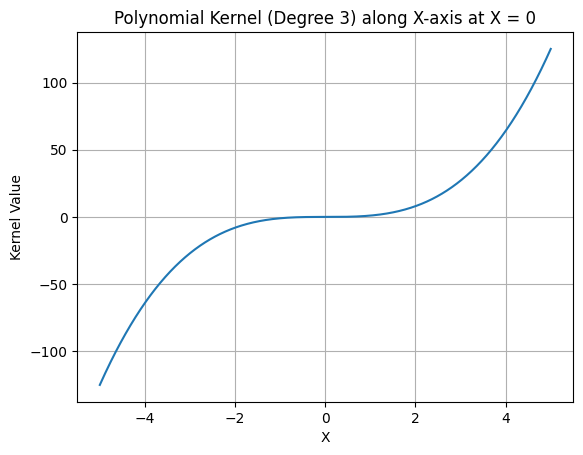

In [ ]:
polynomial_kernel_visualization_1d(degree=3, bias=0, scale=1)

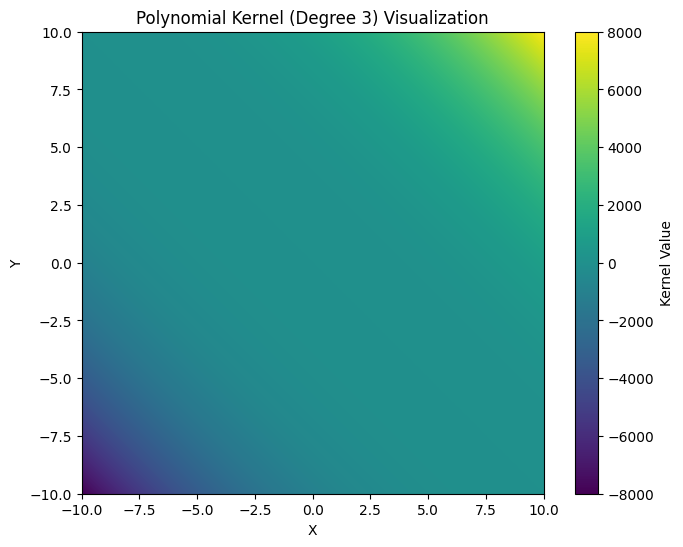

In [ ]:
polynomial_kernel_visualization_2d(degree=3, bias=0, scale=1)

## Sigmoid Kernel

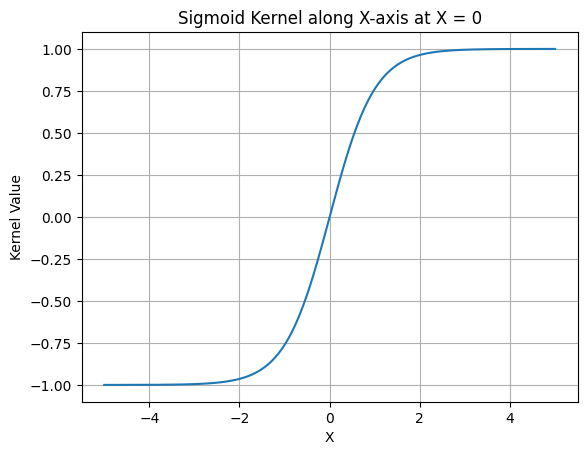

In [ ]:
def sigmoid_kernel_visualization_1d(gamma=1.0, coef0=0.0, axis='x', slice_value=0):
    if axis.lower() == 'x':
        x = np.linspace(-5, 5, 1000)
        y = np.tanh(gamma * x + coef0)
        plt.plot(x, y)
        plt.title('Sigmoid Kernel along X-axis at X = {}'.format(slice_value))
        plt.xlabel('X')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    elif axis.lower() == 'y':
        y = np.linspace(-5, 5, 1000)
        x = np.tanh(gamma * y + coef0)
        plt.plot(y, x)
        plt.title('Sigmoid Kernel along Y-axis at Y = {}'.format(slice_value))
        plt.xlabel('Y')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    else:
        print("Invalid axis. Please choose 'x' or 'y'.")

# example usage
sigmoid_kernel_visualization_1d(gamma=1.0, coef0=0.0, axis='x', slice_value=0)

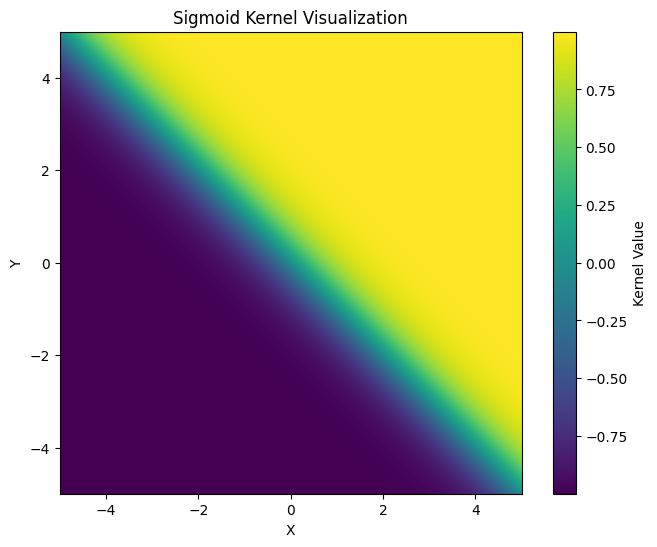

In [ ]:
def sigmoid_kernel_visualization_2d(gamma=1.0, coef0=0.0):
    x = np.linspace(-5, 5, 1000)
    y = np.linspace(-5, 5, 1000)
    X, Y = np.meshgrid(x, y)
    Z = np.tanh(gamma * (X + Y) + coef0)

    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=(-5, 5, -5, 5), cmap='viridis', origin='lower')
    plt.title('Sigmoid Kernel Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Kernel Value')
    plt.show()

# example usage
sigmoid_kernel_visualization_2d(gamma=1.0, coef0=0.0)